# RRNN (LSTM)

## Deep-Learning-master (Jason Brownlee Book)

Univariate LSTM Models
1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


Revisar documentación descargada

## Time Series Forecasting with the LSTM NN in Python (Machine Learning Mastery)

### LSTM for Regression with Time Steps

You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. For example:

```
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```


In [ ]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM with Memory Between Batches

The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(). For example:

```
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
```

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

```
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
This same batch size must then be used later when evaluating the model and making predictions. For example:
```

```
model.predict(trainX, batch_size=batch_size)
We can adapt the previous time step example to use a stateful LSTM. The full code listing is provided below.
```


In [ ]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## How to use Deep Learning for Time Series Forecasting (Towards Data Science)

In [ ]:
# import the packages needed for the study
matplotlib inline
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
# let's see the progress bar
from tqdm import tqdm
tqdm().pandas()

Window Method:
The second method is the window method, how does it work?
You need to take a number of points, in the previous case 20, compute the mean (no difference with the previous method), this point it’s the beginning of the new time series and it is at the position 20 (shift of 19 points). But, instead of shifting to the next 20 points, the window is shifted by one point, compute the mean with the 20 previous points and move again and again by just shifting one step ahead. It’s not a downsampling method but a cleaning method because the effect is to smooth the data points.
Let’s see it in code:

In [ ]:
def mean_sliding_windows(time, flux, lag=5):
    '''
    This function denoise the data naively by sliding a window and make a mean between the lag number points.
    @param time: (list) list of time values
    @param flux: (list) list of floats -> flux of the star
    @param lag: (int) number of points for the mean, default 5
    @return X: (list) time rescaled
    @return y: (list) flux rescaled by mean 
    @return y_std: (list) list of standard deviations for each rescaled points
    '''
    # let's do some simple code
    # Empty lists
    X = []
    y = []
    y_std = []
    j = 0 # increment
    for i in range(int(len(flux)-lag)):
        
        _flux = flux[i:(i+lag)]
        _time = time[i:(i+lag)]
        X.append(np.mean(_time))
        y.append(np.mean(_flux))
        y_std.append(np.std(_flux))         
        
        j+= 1 # we just move with one step 
        
    return X, y, y_std

You can easily use it like that:

```
# reduce the number of points with the mean on 20 points
x, y, y_err  = mean_sliding_windows(df.index,df["001724719_rscl"], 40)
```

df.index correspond to the time of the time series
df[“001724719_rscl”] rescaled flux of the star (“001724719”)
lag=40 is the number of points where the mean and the std will be computed

Well, not so bad. Setting the lag to 40 permits to “predict” or extend the new time series in the small holes. But, if you look closer you’ll see a divergence at the beginning and the end of the portions of the red line. The function can be improved to avoid these artifacts.
For the rest of the study, we will use the time series obtained with the moving average method.

Change the x-axis from values to dates:
You can change the axis if you want with dates. The Kepler mission began on 2009–03–07 and ended in 2017. Pandas has a function called pd.data_range() this function that allows you to create dates from a list constantly incrementing.
df.index = pd.date_range(‘2009–03–07’, periods=len(df.index), freq=’h’)
This line of code will create a new index with a frequency of hours. If you print the result (as below) you’ll find a proper real timescale.

In [ ]:
$ df.index
DatetimeIndex(['2009-03-07 00:00:00', '2009-03-07 01:00:00',
               '2009-03-07 02:00:00', '2009-03-07 03:00:00',
               '2009-03-07 04:00:00', '2009-03-07 05:00:00',
               '2009-03-07 06:00:00', '2009-03-07 07:00:00',
               '2009-03-07 08:00:00', '2009-03-07 09:00:00',
               ...
               '2017-04-29 17:00:00', '2017-04-29 18:00:00',
               '2017-04-29 19:00:00', '2017-04-29 20:00:00',
               '2017-04-29 21:00:00', '2017-04-29 22:00:00',
               '2017-04-29 23:00:00', '2017-04-30 00:00:00',
               '2017-04-30 01:00:00', '2017-04-30 02:00:00'],
              dtype='datetime64[ns]', length=71427, freq='H')

You have now a good timescale for the original time series.
Generate the datasets
So, now that the data reduction functions have been created, we can combine them in another function (shown below) which will take into account the initial dataset and the name of the stars present in the dataset (this part could have been done in the function).

In [ ]:
def reduced_data(df,stars):
    '''
    Function to automatically reduced a dataset 
    @param df: (pandas dataframe) dataframe containing all the data
    @param stars: (list) list containing the name of each stars we want reduced data
    @return df_mean: dataframe containing the data reduced by the mean function
    @return df_slide: dataframe containing the data reduced by the sliding window method
    '''
    df_mean = pd.DataFrame()
    df_slide = pd.DataFrame()
    for i in tqdm(stars):
        
        x , y, y_std = moving_average(df.index, df[i+"_rscl"], lag=25)
        df_mean[i+"_rscl_x"] = x
        df_mean[i+"_rscl_y"] = y
        df_mean[i+"_rscl_y_std"] = y_std
        
        x , y, y_std = mean_sliding_windows(df.index, df[i+"_rscl"], lag=40)
        df_slide[i+"_rscl_x"]= x
        df_slide[i+"_rscl_y"]= y
        df_slide[i+"_rscl_y_std"]= y_std
    
    return df_mean, df_slide

To generate the new data frames do this:

In [ ]:
stars = df.columns
stars = list(set([i.split("_")[0] for i in stars]))
print(f"The number of stars available is: {len(stars)}")
> The number of stars available is: 13

We have 13 stars with 4 data types, corresponding to 52 columns.

In [ ]:
df_mean, df_slide = reduced_data(df,stars)

Perfect, at this point, you have two new datasets containing the data reduced by the moving average and the window method.
Methods
Prepare the data:
In order to use a machine-learning algorithm to predict time series, the data must be prepared accordingly. The data cannot just be set at (x,y) data points. The data must take the form of a series [x1, x2, x3, …, xn] and a predicted value y.
The function below shows you how to set up your dataset:

In [ ]:
def create_dataset(values, look_back=1):
    '''
    Function to prepare a list of (x, y) data points to data for time series learning
    @param values: (list) list of values 
    @param look_back: (int) number of values for the x list [x1, x2, x3, ... , xn] default 1
    @return _x: x values for the time series
    @return _y: y values for the time series 
    '''
    # set empty lists 
	_x, _y = [], []
	for i in range(len(values)-look_back-1):
		a = values[i:(i+look_back)]      # stack a list of values
		_x.append(a)                        # set x
		_y.append(values[i + look_back]) # set y
	return np.array(_x), np.array(_y)

Two important things before starting.
1- The data need to be rescaled
Deep Learning algorithms are better when the data is in the range of [0, 1) to predict time series. To do it simply scikit-learn provides the function MinMaxScaler(). You can configure the feature_range parameter but by default it takes (0, 1). And clean the data of nan values (if you don’t delete the nan values your loss function will be output nan).

In [ ]:
# normalize the dataset 
num = 2 # choose the third star in the dataset
values = df_model[stars[num]+"_rscl_y"].values # extract the list of values
scaler = MinMaxScaler(feature_range=(0, 1)) # make an instance of MinMaxScaler
dataset = scaler.fit_transform(values[~np.isnan(values)].reshape(-1, 1)) # the data will be clean of nan values, rescaled and reshape

2- The data need to be converted into x list and y
Now, we will the create_values() function to generate the data for the models. But, before, I prefer to save the original data by:
df_model = df_mean.save()

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)   # make 80% data train
train = dataset[:train_size] # set the train data
test  = dataset[train_size:] # set the test data 
# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Just take a look at the result:

In [ ]:
trainX[0]
> array([[0.7414906],
       [0.76628096],
       [0.79901113],
       [0.62779976],
       [0.64012722],
       [0.64934765],
       [0.68549234],
       [0.64054092],
       [0.68075644],
       [0.73782449],
       [0.68319294],
       [0.64330245],
       [0.61339268],
       [0.62758265],
       [0.61779702],
       [0.69994317],
       [0.64737128],
       [0.64122564],
       [0.62016833],
       [0.47867125]]) # 20 values in the first value of x train data
trainY[0]
> array([0.46174275]) # the corresponding y value

Metrics
What metrics do we use for time series prediction? We can use the mean absolute error and the mean squared error. They are given by the function:

In [ ]:
def metrics_time_series(y_true, y_pred):
    '''
    Compute the MAE and MSE metrics from sklearn.metrics
    @param y_true: (list) list of the true values
    @param y_pred: (list) list of predicted values
    @return mae, mse: (float), (float) values of metrics MAE and MSE 
    '''
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    print(f"The mean absolute error is: {mae}")
    print(f"The mean squared error is: {mse}")
    return mae, mse

You need to first import the functions:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

RNNs:
You can implement easily the RNN family with Keras in few lines of code. Here you can use this function which will configure your RNN. You need to first import the different models from Keras like:

In [ ]:
# import some packages
import tensorflow as tf
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Dropout

Now, we have the models imported from Keras. The function below can generate a simple model (SimpleRNN, LSTM, GRU). Or, two models (identical) can be stacked, or used in Bidirectional or a stack of two Bidirectional models. You can also add the CNN part (Conv1D)with MaxPooling1D and dropout.

In [ ]:
def time_series_deep_learning(x_train, y_train, x_test, y_test, model_dl=LSTM ,  unit=4, look_back=20, cnn=False, bidirection=False, stacked=False):
    '''
    Generate RNN models with different combinations. Can be simple, stacked or bidirectional. Models can also be used with a CNN part. 
    @param x_train: (matrix) x training data with dimension (samples, time steps, features)
    @param y_train: (list) predict data 
    @param x_test: (matrix) x testing data with dimension (samples, time steps, features)
    @param y_test: (list) predict data 
    @param model_dl: (model) rnn type model (LSTM, GRU) default LSTM
    @param unit: (int) number of cells of the RNN default 4
    @param look_back: (int) number of values in x list, configure the shape of the RNN
    @param cnn: (bool) add cnn part of the model default false
    @param bidirection: (bool) add bidirectional model for the RNN default false
    @param stacked: (bool) stacked two layers of RNN models default false
    @return train_predict: (list) predicted values of x_train
    @return train_y: (list) real y values 
    @return test_predict: (list) predicted test values of x_test
    @return test_y: (list) real test values
    @return (dataframe) containing the name of the model and the metrics
    '''
    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    # instance of a Sequential model
    model = Sequential()
    
    if cnn: # test if cnn part is needed 
        print("CNN")
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.2))
    
    if not bidirection and not stacked: # test if simple model is needed
        print("Simple Model")
        name = model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not bidirection: # test if bidirectional  model is needed
        print("Stacked Model")
        name = "Stacked_"+model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True))
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not stacked: # test if stacked models are needed
        print("Bidirectional Model")
        name = "Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
    else: # test if bidirectional and stacked models are needed
        print("Stacked Bidirectional Model")
        name = "Stacked_Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True)))
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
        
    if cnn: # update name with cnn part 
        name = "CNN_"+name
    
    # add Dense layer with one layer and activation function linear to predict continuous values 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss but can be replace by 'mean_absolute_error'
    model.fit(trainX, trainY, epochs=1000, batch_size=100, callbacks=[es], verbose=0)
    
    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(y_test)
    
    # compute the metrics 
    print("Train")
    mae_train, mse_train = metrics_time_series( train_y, train_predict)
    print("Test")
    mae_test, mse_test = metrics_time_series( test_y, test_predict)
    
    return train_predict, train_y, test_predict, test_y, pd.DataFrame([name, mae_train, mse_train, mae_test, mse_test], index=["Name", "mae_train", "mse_train", "mae_test", "mse_test"]).T


This function computes the metrics for the training part and the test part and returned the results in a data frame. Look at how you how to use it for five examples.

### LSTM:

In [ ]:
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20)
# plot the resuts of the prediction
> plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)
# save the metrics per model in the dataframe df_results
> df_results = df_results.append(res)

### GRU:

In [ ]:
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=GRU,  unit=12, look_back=20)

### Stack LSTM:

In [ ]:
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20, stacked=True)

### Bidirectional LSTM:

In [ ]:
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20, bidirection=True)

### CNN-LSTM:

In [ ]:
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20, cnn=True)

### Results
The results are pretty good considering the data. We can see that deep learning RNN can reproduce with good accuracy of the data. The figure below shows the result of the prediction by the LSTM model.


Table 1: Results of the different RNN models, showing the MAE and MSE metrics

```
        Name    | MAE Train | MSE Train | MAE Test | MSE Test
--------------------------------------------------------------------
            GRU |   4.24    |   34.11   |   4.15   |   31.47 
           LSTM |   4.26    |   34.54   |   4.16   |   31.64 
      Stack_GRU |   4.19    |   33.89   |   4.17   |   32.01
      SimpleRNN |   4.21    |   34.07   |   4.18   |   32.41
           LSTM |   4.28    |   35.1    |   4.21   |   31.9
         Bi_GRU |   4.21    |   34.34   |   4.22   |   32.54
  Stack_Bi_LSTM |   4.45    |   36.83   |   4.24   |   32.22
        Bi_LSTM |   4.31    |   35.37   |   4.27   |   32.4
Stack_SimpleRNN |   4.4     |   35.62   |   4.27   |   33.94
      SimpleRNN |   4.44    |   35.94   |   4.31   |   34.37 
     Stack_LSTM |   4.51    |   36.78   |   4.4    |   34.28
 Stacked_Bi_GRU |   4.56    |   37.32   |   4.45   |   35.34
       CNN_LSTM |   5.01    |   45.85   |   4.55   |   36.29
        CNN_GRU |   5.05    |   46.25   |   4.66   |   37.17 
  CNN_Stack_GRU |   5.07    |   45.92   |   4.7    |   38.64

```

The Table 1 shows the mean absolute error (MAE) and the mean squared error (MSE) for the train set and the test set for the RNN family. The GRU shows the best result on the test set with an MAE of 4.15 and an MSE of 31.47.

### Discussion

The results are good and reproduced the lightcurves of the different stars (see notebook). However, the fluctuations are not perfectly reproduced, the peaks do not have the same intensity and the flux is slightly shifted. A potential correction could be made via the attention mechanisms (Transformers[10]). Another way is to tune the models, the number of layers (stack), the number of units (cells), the combination of different RNN algorithms, new loss function or activation function, etc.

### Conclusion
This article shows the possibilities of combining so-called artificial intelligence methods with time series. The power of memory algorithms (RNN, LSTM, GRU) makes it possible to accurately reproduce sporadic fluctuations of events. In our case, the stellar flux exhibited quite strong and marked fluctuations that the methods have been able to capture.
This study shows that time series are no longer reserved for statistical methods such as the ARIMA[4] model.

# CÓDIGO TFM

### CARGA DE LIBRERÍAS Y DATOS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 314

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# for older versions:
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
#from numpy.random import seed
#seed(314)
#import tensorflow as tf
#tf.random.set_seed(314) 

In [4]:
!pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.1
    Uninstalling importlib-metadata-4.10.1:
      Successfully uninstalled importlib-metadata-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [5]:
# import the packages needed for the study
#matplotlib inline
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as disp_Image
import scikeras
import sklearn
from keras.utils.vis_utils import plot_model

# let's see the progress bar
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]


#### CARGA VAR. TARGET Y VARS. EXPLICATIVAS

In [6]:
# CARGA DATOS


data_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2014-2021_VARS. COMPLETAS.csv"

Data_df = pd.read_csv(data_in1, sep=",", header='infer', index_col=None, infer_datetime_format=True, 
                      encoding="ISO 8859-1", decimal='.', na_values=np.nan) #, dtype=col_types)


In [7]:
# CARGA DATOS

'''
data_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2014-2021_VARS. COMPLETAS + CONSUMO.csv"

Data_df = pd.read_csv(data_in1, sep=",", header='infer', index_col=None, infer_datetime_format=True, 
                         encoding="ISO 8859-1", decimal='.', na_values=np.nan) #, dtype=col_types)
'''

'\ndata_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2014-2021_VARS. COMPLETAS + CONSUMO.csv"\n\nData_df = pd.read_csv(data_in1, sep=",", header=\'infer\', index_col=None, infer_datetime_format=True, \n                         encoding="ISO 8859-1", decimal=\'.\', na_values=np.nan) #, dtype=col_types)\n'

In [8]:
# CARGA DATOS

'''
data_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022_MACRO.csv"

col_types = {'DemReal':'float64', 'DemPrevD1':'float64', 'N_ano':'int64', 'Clasif_dia':'string', 'Lab_previo_fest':'int64', 
             'Lab_post_fest':'int64', 'Huelga_General':'int64', 'Tmax':'float64', 'Tmin':'float64',
             'Total_Indust':'float64', 'Indust_01':'float64', 'Indust_02':'float64', 'Indust_03':'float64', 
             'Indust_04':'float64', 'Indust_05':'float64', 'Indust_06':'float64', 'Indust_07':'float64',
             'Indust_08':'float64', 'Indust_09':'float64', 'Total_Servic':'float64', 'Servic_01':'float64', 'Servic_02':'float64', 
             'Macro_01':'float64', 'Macro_02':'float64', 'Macro_03':'float64', 'Macro_04':'float64', 'Macro_05':'float64', 'Macro_06':'float64', 
             'Dia_sem_SIN':'float64', 'Dia_sem_COS':'float64', 'N_mes_SIN':'float64', 'N_mes_COS':'float64', 
             'N_dia_mes_SIN':'float64', 'N_dia_mes_COS':'float64'}

Data_df = pd.read_csv(data_in1, sep=",", header='infer', index_col=None, infer_datetime_format=True, 
                         encoding="ISO 8859-1", decimal='.', na_values=np.nan, dtype=col_types)
'''

'\ndata_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022_MACRO.csv"\n\ncol_types = {\'DemReal\':\'float64\', \'DemPrevD1\':\'float64\', \'N_ano\':\'int64\', \'Clasif_dia\':\'string\', \'Lab_previo_fest\':\'int64\', \n             \'Lab_post_fest\':\'int64\', \'Huelga_General\':\'int64\', \'Tmax\':\'float64\', \'Tmin\':\'float64\',\n             \'Total_Indust\':\'float64\', \'Indust_01\':\'float64\', \'Indust_02\':\'float64\', \'Indust_03\':\'float64\', \n             \'Indust_04\':\'float64\', \'Indust_05\':\'float64\', \'Indust_06\':\'float64\', \'Indust_07\':\'float64\',\n             \'Indust_08\':\'float64\', \'Indust_09\':\'float64\', \'Total_Servic\':\'float64\', \'Servic_01\':\'float64\', \'Servic_02\':\'float64\', \n             \'Macro_01\':\'float64\', \'Macro_02\':\'float64\', \'Macro_03\':\'float64\', \'Macro_04\':\'float64\', \'Macro_05\':\'float64\', \'Macro_06\':\'float64\', \n             \'Dia_sem_SIN\':\'float64\', \'Dia_sem_COS\':\'float64\', \'N_m

In [9]:
# CARGA DATOS

'''
data_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022_IND_SELEC.csv"

col_types = {'DemReal':'float64', 'DemPrevD1':'float64', 'N_ano':'int64', 'Clasif_dia':'string', 'Lab_previo_fest':'int64', 
             'Lab_post_fest':'int64', 'Huelga_General':'int64', 'Tmax':'float64', 'Tmin':'float64',
             'Total_Indust':'float64', 'Indust_01':'float64', 'Indust_02':'float64', 'Indust_03':'float64', 
             'Indust_04':'float64', 'Indust_06':'float64','Indust_08':'float64', 'Indust_09':'float64', 
             'Dia_sem_SIN':'float64', 'Dia_sem_COS':'float64', 'N_mes_SIN':'float64', 'N_mes_COS':'float64', 
             'N_dia_mes_SIN':'float64', 'N_dia_mes_COS':'float64'}

Data_df = pd.read_csv(data_in1, sep=",", header='infer', index_col=None, infer_datetime_format=True, 
                         encoding="ISO 8859-1", decimal='.', na_values=np.nan, dtype=col_types)
'''

'\ndata_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022_IND_SELEC.csv"\n\ncol_types = {\'DemReal\':\'float64\', \'DemPrevD1\':\'float64\', \'N_ano\':\'int64\', \'Clasif_dia\':\'string\', \'Lab_previo_fest\':\'int64\', \n             \'Lab_post_fest\':\'int64\', \'Huelga_General\':\'int64\', \'Tmax\':\'float64\', \'Tmin\':\'float64\',\n             \'Total_Indust\':\'float64\', \'Indust_01\':\'float64\', \'Indust_02\':\'float64\', \'Indust_03\':\'float64\', \n             \'Indust_04\':\'float64\', \'Indust_06\':\'float64\',\'Indust_08\':\'float64\', \'Indust_09\':\'float64\', \n             \'Dia_sem_SIN\':\'float64\', \'Dia_sem_COS\':\'float64\', \'N_mes_SIN\':\'float64\', \'N_mes_COS\':\'float64\', \n             \'N_dia_mes_SIN\':\'float64\', \'N_dia_mes_COS\':\'float64\'}\n\nData_df = pd.read_csv(data_in1, sep=",", header=\'infer\', index_col=None, infer_datetime_format=True, \n                         encoding="ISO 8859-1", decimal=\'.\', na_values=np.nan, dtype

In [10]:
# CARGA DATOS

'''
data_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022.csv"

col_types = {'DemReal':'float64', 'DemPrevD1':'float64', 'N_ano':'int64', 'Clasif_dia':'string', 'Lab_previo_fest':'int64', 
             'Lab_post_fest':'int64', 'Huelga_General':'int64', 'Tmax':'float64', 'Tmin':'float64',
             'Total_Indust':'float64', 'Indust_01':'float64', 'Indust_02':'float64', 'Indust_03':'float64', 
             'Indust_04':'float64', 'Indust_05':'float64', 'Indust_06':'float64', 'Indust_07':'float64', 
             'Indust_08':'float64', 'Indust_09':'float64','Indust_10':'float64', 'Total_Servic':'float64', 
             'Servic_01':'float64', 'Servic_02':'float64', 'Dia_sem_SIN':'float64', 'Dia_sem_COS':'float64', 
             'N_mes_SIN':'float64', 'N_mes_COS':'float64', 'N_dia_mes_SIN':'float64', 'N_dia_mes_COS':'float64'}

Data_df = pd.read_csv(data_in1, sep=",", header='infer', index_col=None, infer_datetime_format=True, 
                         encoding="ISO 8859-1", decimal='.', na_values=np.nan, dtype=col_types)
'''

'\ndata_in1 = "/content/drive/MyDrive/TFM/Data_in/Dataset_MODELO_2019-2022.csv"\n\ncol_types = {\'DemReal\':\'float64\', \'DemPrevD1\':\'float64\', \'N_ano\':\'int64\', \'Clasif_dia\':\'string\', \'Lab_previo_fest\':\'int64\', \n             \'Lab_post_fest\':\'int64\', \'Huelga_General\':\'int64\', \'Tmax\':\'float64\', \'Tmin\':\'float64\',\n             \'Total_Indust\':\'float64\', \'Indust_01\':\'float64\', \'Indust_02\':\'float64\', \'Indust_03\':\'float64\', \n             \'Indust_04\':\'float64\', \'Indust_05\':\'float64\', \'Indust_06\':\'float64\', \'Indust_07\':\'float64\', \n             \'Indust_08\':\'float64\', \'Indust_09\':\'float64\',\'Indust_10\':\'float64\', \'Total_Servic\':\'float64\', \n             \'Servic_01\':\'float64\', \'Servic_02\':\'float64\', \'Dia_sem_SIN\':\'float64\', \'Dia_sem_COS\':\'float64\', \n             \'N_mes_SIN\':\'float64\', \'N_mes_COS\':\'float64\', \'N_dia_mes_SIN\':\'float64\', \'N_dia_mes_COS\':\'float64\'}\n\nData_df = pd.read_csv

In [11]:
Data_df['Fecha'] = pd.to_datetime(Data_df['Fecha'])
Data_df['Clasif_dia'] = Data_df['Clasif_dia'].astype({'Clasif_dia':'string'})

In [12]:
Data_df['Clasif_dia']

0            Festivo
1          Laborable
2          Laborable
3          Laborable
4       No Laborable
            ...     
2917       Laborable
2918       Laborable
2919       Laborable
2920       Laborable
2921       Laborable
Name: Clasif_dia, Length: 2922, dtype: string

In [13]:
Data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Columns: 123 entries, Fecha to N_dia_mes_COS
dtypes: datetime64[ns](1), float64(117), int64(4), string(1)
memory usage: 2.7 MB


In [14]:
print(f'Columna: "Clasif_dia", Nº categorías: {len(Data_df.Clasif_dia.value_counts().index)}, Categorías: {list(Data_df.Clasif_dia.value_counts().index)}')

Columna: "Clasif_dia", Nº categorías: 3, Categorías: ['Laborable', 'No Laborable', 'Festivo']


In [15]:
Data_df.shape

(2922, 123)

In [16]:
Data_df

,Fecha,DemReal,N_ano,Clasif_dia,Lab_previo_fest,Lab_post_fest,Huelga_General,A3_Tmax,A3_Tmin,A4_Tmax,A4_Tmin,B3_Tmax,B3_Tmin,B4_Tmax,B4_Tmin,C1_Tmax,C1_Tmin,C2_Tmax,C2_Tmin,C3_Tmax,C3_Tmin,C4_Tmax,C4_Tmin,D1_Tmax,D1_Tmin,D2_Tmax,D2_Tmin,D3_Tmax,D3_Tmin,E1_Tmax,E1_Tmin,Ind_Indust1,Ind_Indust2,Ind_Indust3,Ind_Indust4,Ind_Indust5,Ind_Indust6,Ind_Indust7,Ind_Indust8,Ind_Indust9,...,Ind_Indust56,Ind_Serv1,Ind_Serv2,Ind_Serv3,Ind_Serv4,Ind_Serv5,Ind_Serv6,Ind_Serv7,Ind_Serv8,Ind_Serv9,Ind_Serv10,Ind_Empleo1,Ind_Empleo2,Ind_Empleo3,Ind_Empleo4,Ind_Cemento,Ind_Precios1,Ind_Precios2,Ind_Precios3,Ind_Precios4,Ind_Precios5,Ind_Precios6,Ind_Precios7,Ind_Precios8,Ind_Precios9,Ind_Precios10,Ind_Precios11,Ind_Precios12,Ind_Precios13,Ind_Precios14,Ind_Fabr1,Ind_Fabr2,Dia_sem_SIN,Dia_sem_COS,N_mes_SIN,N_mes_COS,N_semana_SIN,N_semana_COS,N_dia_mes_SIN,N_dia_mes_COS
0,2014-01-01,552505.0,2014,Festivo,0,0,0,1.075525,0.686883,0.321397,0.193091,1.837300,0.817933,1.322792,0.799655,1.467908,0.765237,0.383216,0.098709,1.000828,0.404868,0.540501,0.289468,0.838032,0.377539,2.170870,0.797707,2.380815,1.262967,0.440332,0.212258,92.714,94.924,88.609,88.971,118.756,84.423,95.362,100.554,97.371,...,78.839,101.200,102.285,79.250,99.590,114.437,99.231,91.033,84.232,111.175,120.268,16258042.0,6158894.0,367860.0,4333478.0,999.93,101.512,98.031,97.909,107.682,106.155,100.848,100.095,107.607,102.953,102.250,97.984,97.195,95.885,101.512,40.0,334.0,0.974928,-0.222521,0.0,1.000000,0.000000,1.000000,0.000000,1.000000
1,2014-01-02,676599.0,2014,Laborable,0,1,0,0.993990,0.773938,0.322963,0.247630,1.785439,1.149526,1.365969,1.011580,1.535562,0.930120,0.483443,0.201296,0.978013,0.640123,0.594990,0.485532,0.901187,0.549501,2.623668,1.505318,2.750692,1.906294,0.555394,0.320761,92.714,94.924,88.609,88.971,118.756,84.423,95.362,100.554,97.371,...,78.839,101.200,102.285,79.250,99.590,114.437,99.231,91.033,84.232,111.175,120.268,16258042.0,6158894.0,367860.0,4333478.0,999.93,101.512,98.031,97.909,107.682,106.155,100.848,100.095,107.607,102.953,102.250,97.984,97.195,95.885,101.512,40.0,334.0,0.433884,-0.900969,0.0,1.000000,0.000000,1.000000,0.201299,0.979530
2,2014-01-03,683165.0,2014,Laborable,0,0,0,1.140597,0.701883,0.365626,0.244100,2.063487,1.227381,1.663711,1.094498,1.506289,0.916955,0.476590,0.245751,1.132918,0.706598,0.650002,0.481697,0.894948,0.589689,2.743285,1.473110,3.186326,2.184169,0.580318,0.319916,92.714,94.924,88.609,88.971,118.756,84.423,95.362,100.554,97.371,...,78.839,101.200,102.285,79.250,99.590,114.437,99.231,91.033,84.232,111.175,120.268,16258042.0,6158894.0,367860.0,4333478.0,999.93,101.512,98.031,97.909,107.682,106.155,100.848,100.095,107.607,102.953,102.250,97.984,97.195,95.885,101.512,40.0,334.0,-0.433884,-0.900969,0.0,1.000000,0.000000,1.000000,0.394356,0.918958
3,2014-01-04,644653.0,2014,Laborable,0,0,0,1.196653,0.711374,0.352016,0.203723,2.122515,1.041416,1.610895,0.892371,1.259962,0.588369,0.403634,0.205218,1.193301,0.484345,0.622802,0.262891,0.754728,0.318770,2.432888,0.690977,2.827745,0.947379,0.430435,-0.019894,92.714,94.924,88.609,88.971,118.756,84.423,95.362,100.554,97.371,...,78.839,101.200,102.285,79.250,99.590,114.437,99.231,91.033,84.232,111.175,120.268,16258042.0,6158894.0,367860.0,4333478.0,999.93,101.512,98.031,97.909,107.682,106.155,100.848,100.095,107.607,102.953,102.250,97.984,97.195,95.885,101.512,40.0,334.0,-0.974928,-0.222521,0.0,1.000000,0.000000,1.000000,0.571268,0.820763
4,2014-01-05,608007.0,2014,No Laborable,0,0,0,1.036813,0.538884,0.333919,0.156192,1.757951,0.908911,1.411948,0.603723,1.529541,0.676945,0.395908,0.154978,0.970069,0.321578,0.570200,0.182614,0.855998,0.334410,1.934328,0.603399,2.243560,0.810235,0.485941,-0.020853,92.714,94.924,88.609,88.971,118.756,84.423,95.362,100.554,97.371,...,78.839,101.200,102.285,79.250,99.590,114.437,99.231,91.033,84.232,111.175,120.268,16258042.0,6158894.0,367860.0,4333478.0,999.93,101.512,98.031,97.909,107.682,106.155,100.848,100.095,107.607,102.953,102.250,97.984,97.195,95.885,101.512

#### CARGA "DEMANDA PREVISTA (D+1)" (VARIABLE DE CONTRASTE)

In [17]:
# CARGA DATOS

data_in1b = '/content/drive/MyDrive/TFM/Data_in/DemPrevD1-Day_2019-2022.csv'

DemPrevD1_df = pd.read_csv(data_in1b, sep=",", header='infer', index_col=None, infer_datetime_format=True, decimal='.')

In [18]:
DemPrevD1_df['datetime'] = pd.to_datetime(DemPrevD1_df['datetime'], utc=True).dt.date
DemPrevD1_df['Fecha'] = pd.to_datetime(DemPrevD1_df['datetime'])
DemPrevD1_df.rename(columns = {'Previsión diaria D+1 demanda':'DemPrevD1'}, inplace=True)
del DemPrevD1_df['datetime']
cols_order = ['Fecha', 'DemPrevD1']
DemPrevD1_df = DemPrevD1_df[cols_order]

In [19]:
mask = (DemPrevD1_df['Fecha'] >= '2019-01-01') & (DemPrevD1_df['Fecha'] <= '2021-12-31')
DemPrevD1_df = DemPrevD1_df.loc[mask]
DemPrevD1_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
#DemPrevD1_df = DemPrevD1_df.drop_duplicates(subset=['Fecha'], keep='last')

In [20]:
print(DemPrevD1_df.info())
print(DemPrevD1_df.head())
print(DemPrevD1_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      1096 non-null   datetime64[ns]
 1   DemPrevD1  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.2 KB
None
       Fecha  DemPrevD1
0 2019-01-01   554520.0
1 2019-01-02   708859.0
2 2019-01-03   770397.0
3 2019-01-04   752240.0
4 2019-01-05   673904.0
          Fecha  DemPrevD1
1091 2021-12-27   637904.0
1092 2021-12-28   632190.0
1093 2021-12-29   630840.0
1094 2021-12-30   617470.0
1095 2021-12-31   570939.0


### SELECCIÓN DE VARIABLES

In [21]:
 vars_expl = ['Lab_previo_fest', 'Lab_post_fest', 'Huelga_General', 'A3_Tmax', 'A3_Tmin', 'A4_Tmax', 'A4_Tmin', 'B3_Tmax', 'B3_Tmin', 'B4_Tmax', 'B4_Tmin', 'C1_Tmax', 'C1_Tmin', 'C2_Tmax', 'C2_Tmin', 'C3_Tmax',
  'C3_Tmin', 'C4_Tmax', 'C4_Tmin', 'D1_Tmax', 'D1_Tmin', 'D2_Tmax', 'D2_Tmin', 'D3_Tmax', 'D3_Tmin', 'E1_Tmax', 'E1_Tmin', 'Ind_Indust4', 'Ind_Indust5', 'Ind_Indust8', 'Ind_Indust9', 'Ind_Indust11',
  'Ind_Indust12', 'Ind_Indust13', 'Ind_Indust14', 'Ind_Indust15', 'Ind_Indust16', 'Ind_Indust17', 'Ind_Indust19', 'Ind_Indust21', 'Ind_Indust22', 'Ind_Indust23', 'Ind_Indust24', 'Ind_Indust25',
  'Ind_Indust26', 'Ind_Indust27', 'Ind_Indust30', 'Ind_Indust35', 'Ind_Indust37', 'Ind_Indust40', 'Ind_Indust41', 'Ind_Indust53', 'Ind_Indust56', 'Ind_Serv3', 'Ind_Serv8', 'Ind_Serv10', 'Ind_Empleo2',
  'Ind_Empleo3', 'Ind_Cemento', 'Ind_Precios4', 'Ind_Fabr1', 'Ind_Fabr2', 'Dia_sem_SIN', 'Dia_sem_COS', 'N_mes_SIN', 'N_mes_COS', 'N_semana_SIN', 'N_semana_COS', 'N_dia_mes_SIN', 'N_dia_mes_COS']

In [22]:
selected_cols = ['Fecha', 'DemReal', 'Clasif_dia'] + vars_expl

In [23]:
len(selected_cols)

73

In [24]:
Data_df = Data_df[selected_cols]

In [25]:
'''
R2 = 0.92028960134346
RSME = 17550.258030117446
MAPE = 0.02038180492068384
(0.92028960134346, 17550.258030117446, 0.02038180492068384)
'''

'\nR2 = 0.92028960134346\nRSME = 17550.258030117446\nMAPE = 0.02038180492068384\n(0.92028960134346, 17550.258030117446, 0.02038180492068384)\n'

In [26]:
'''
 vars_expl = ['Lab_previo_fest', 'Lab_post_fest', 'Huelga_General', 'A3_TmaxC', 'A3_TminC', 'A4_TmaxC', 'A4_TminC', 'B3_TmaxC', 'B3_TminC', 'B4_TmaxC', 'B4_TminC', 'C1_TmaxC', 'C1_TminC', 'C2_TmaxC', 'C2_TminC', 'C3_TmaxC',
  'C3_TminC', 'C4_TmaxC', 'C4_TminC', 'D1_TmaxC', 'D1_TminC', 'D2_TmaxC', 'D2_TminC', 'D3_TmaxC', 'D3_TminC', 'E1_TmaxC', 'E1_TminC', 'Ind_Indust4', 'Ind_Indust5', 'Ind_Indust8', 'Ind_Indust9', 'Ind_Indust11',
  'Ind_Indust12', 'Ind_Indust13', 'Ind_Indust14', 'Ind_Indust15', 'Ind_Indust16', 'Ind_Indust17', 'Ind_Indust19', 'Ind_Indust21', 'Ind_Indust22', 'Ind_Indust23', 'Ind_Indust24', 'Ind_Indust25',
  'Ind_Indust26', 'Ind_Indust27', 'Ind_Indust30', 'Ind_Indust35', 'Ind_Indust37', 'Ind_Indust40', 'Ind_Indust41', 'Ind_Indust53', 'Ind_Indust56', 'Ind_Serv3', 'Ind_Serv8', 'Ind_Serv10', 'Ind_Empleo2',
  'Ind_Empleo3', 'Ind_Cemento', 'Ind_Precios4', 'Ind_Fabr1', 'Ind_Fabr2', 'Dia_sem_SIN', 'Dia_sem_COS', 'N_mes_SIN', 'N_mes_COS', 'N_semana_SIN', 'N_semana_COS', 'N_dia_mes_SIN', 'N_dia_mes_COS']
'''

"\n vars_expl = ['Lab_previo_fest', 'Lab_post_fest', 'Huelga_General', 'A3_TmaxC', 'A3_TminC', 'A4_TmaxC', 'A4_TminC', 'B3_TmaxC', 'B3_TminC', 'B4_TmaxC', 'B4_TminC', 'C1_TmaxC', 'C1_TminC', 'C2_TmaxC', 'C2_TminC', 'C3_TmaxC',\n  'C3_TminC', 'C4_TmaxC', 'C4_TminC', 'D1_TmaxC', 'D1_TminC', 'D2_TmaxC', 'D2_TminC', 'D3_TmaxC', 'D3_TminC', 'E1_TmaxC', 'E1_TminC', 'Ind_Indust4', 'Ind_Indust5', 'Ind_Indust8', 'Ind_Indust9', 'Ind_Indust11',\n  'Ind_Indust12', 'Ind_Indust13', 'Ind_Indust14', 'Ind_Indust15', 'Ind_Indust16', 'Ind_Indust17', 'Ind_Indust19', 'Ind_Indust21', 'Ind_Indust22', 'Ind_Indust23', 'Ind_Indust24', 'Ind_Indust25',\n  'Ind_Indust26', 'Ind_Indust27', 'Ind_Indust30', 'Ind_Indust35', 'Ind_Indust37', 'Ind_Indust40', 'Ind_Indust41', 'Ind_Indust53', 'Ind_Indust56', 'Ind_Serv3', 'Ind_Serv8', 'Ind_Serv10', 'Ind_Empleo2',\n  'Ind_Empleo3', 'Ind_Cemento', 'Ind_Precios4', 'Ind_Fabr1', 'Ind_Fabr2', 'Dia_sem_SIN', 'Dia_sem_COS', 'N_mes_SIN', 'N_mes_COS', 'N_semana_SIN', 'N_semana_COS', 'N

In [27]:
#selected_cols = ['Fecha', 'DemReal', 'Clasif_dia'] + vars_expl

In [28]:
#Data_df = Data_df[selected_cols]

In [29]:
'''
R2 = 0.80
'''

'\nR2 = 0.80\n'

### PREPARACIÓN DATASETS "TRAIN" Y "TEST"

In [30]:
DataTrain_df = Data_df[Data_df['Fecha']<'2021-01-01'].copy()
DataTrain_df.drop(axis=1, columns=['Fecha'], level=None, inplace=True, errors='raise')
#DataTrain_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [31]:
print(DataTrain_df.shape)
DataTrain_df.info()

(2557, 72)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2556
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DemReal          2557 non-null   float64
 1   Clasif_dia       2557 non-null   string 
 2   Lab_previo_fest  2557 non-null   int64  
 3   Lab_post_fest    2557 non-null   int64  
 4   Huelga_General   2557 non-null   int64  
 5   A3_Tmax          2557 non-null   float64
 6   A3_Tmin          2557 non-null   float64
 7   A4_Tmax          2557 non-null   float64
 8   A4_Tmin          2557 non-null   float64
 9   B3_Tmax          2557 non-null   float64
 10  B3_Tmin          2557 non-null   float64
 11  B4_Tmax          2557 non-null   float64
 12  B4_Tmin          2557 non-null   float64
 13  C1_Tmax          2557 non-null   float64
 14  C1_Tmin          2557 non-null   float64
 15  C2_Tmax          2557 non-null   float64
 16  C2_Tmin          2557 non-null   float64
 17  C3_

In [32]:
DataTest_df = Data_df[Data_df['Fecha']>='2021-01-01'].copy()
DataTest_df.drop(axis=1, columns=['Fecha'], level=None, inplace=True, errors='raise')
#DataTest_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [33]:
print(DataTest_df.shape)
DataTest_df.info()

(365, 72)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 2557 to 2921
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DemReal          365 non-null    float64
 1   Clasif_dia       365 non-null    string 
 2   Lab_previo_fest  365 non-null    int64  
 3   Lab_post_fest    365 non-null    int64  
 4   Huelga_General   365 non-null    int64  
 5   A3_Tmax          365 non-null    float64
 6   A3_Tmin          365 non-null    float64
 7   A4_Tmax          365 non-null    float64
 8   A4_Tmin          365 non-null    float64
 9   B3_Tmax          365 non-null    float64
 10  B3_Tmin          365 non-null    float64
 11  B4_Tmax          365 non-null    float64
 12  B4_Tmin          365 non-null    float64
 13  C1_Tmax          365 non-null    float64
 14  C1_Tmin          365 non-null    float64
 15  C2_Tmax          365 non-null    float64
 16  C2_Tmin          365 non-null    float64
 17  C3

In [34]:
DataTest_df.columns

Index(['DemReal', 'Clasif_dia', 'Lab_previo_fest', 'Lab_post_fest',
       'Huelga_General', 'A3_Tmax', 'A3_Tmin', 'A4_Tmax', 'A4_Tmin', 'B3_Tmax',
       'B3_Tmin', 'B4_Tmax', 'B4_Tmin', 'C1_Tmax', 'C1_Tmin', 'C2_Tmax',
       'C2_Tmin', 'C3_Tmax', 'C3_Tmin', 'C4_Tmax', 'C4_Tmin', 'D1_Tmax',
       'D1_Tmin', 'D2_Tmax', 'D2_Tmin', 'D3_Tmax', 'D3_Tmin', 'E1_Tmax',
       'E1_Tmin', 'Ind_Indust4', 'Ind_Indust5', 'Ind_Indust8', 'Ind_Indust9',
       'Ind_Indust11', 'Ind_Indust12', 'Ind_Indust13', 'Ind_Indust14',
       'Ind_Indust15', 'Ind_Indust16', 'Ind_Indust17', 'Ind_Indust19',
       'Ind_Indust21', 'Ind_Indust22', 'Ind_Indust23', 'Ind_Indust24',
       'Ind_Indust25', 'Ind_Indust26', 'Ind_Indust27', 'Ind_Indust30',
       'Ind_Indust35', 'Ind_Indust37', 'Ind_Indust40', 'Ind_Indust41',
       'Ind_Indust53', 'Ind_Indust56', 'Ind_Serv3', 'Ind_Serv8', 'Ind_Serv10',
       'Ind_Empleo2', 'Ind_Empleo3', 'Ind_Cemento', 'Ind_Precios4',
       'Ind_Fabr1', 'Ind_Fabr2', 'Dia_sem_SIN', 'Dia_

In [35]:
#X_train = DataTrain_df.drop(axis=1, columns='DemReal', level=None, inplace=False, errors='raise')
#y_train = DataTrain_df['DemReal']
#print(X_train.shape)
#print(y_train.shape)

In [36]:
# retrieve numpy array
#X_train = X_train.values
#y_train = y_train.values.reshape((len(y_train), 1))

In [37]:
#X_test = DataTest_df.drop(axis=1, columns='DemReal', level=None, inplace=False, errors='raise')
#y_test = DataTest_df['DemReal']
#print(X_test.shape)
#print(y_test.shape)

In [38]:
# retrieve numpy array
#X_test = X_test.values
#y_test = y_test.values.reshape((len(y_test), 1))

### DEF. VAR. TARGET Y VARS. EXPLICATIVAS (NUMÉRICAS Y CATEGÓRICAS)

In [39]:
# prepare input data

def Xnum_Xcat_y(df_input, col_y=[], cols_num=[], cols_cat=[], cols_drop=[], cols_left=[]):

  if type(col_y)!=list:
    col_y = [col_y]
  if type(cols_num)!=list:
    cols_num = [cols_num]
  if type(cols_cat)!=list:
    cols_cat = [cols_cat]

  if type(cols_drop)!=list:
    cols_drop = [cols_drop]
  if cols_drop!=[]:
    df_input = df_input.drop(axis=1, columns=cols_drop, level=None, inplace=False, errors='raise')
  if type(cols_left)!=list:
    cols_left = [cols_left]

  if len(col_y+cols_num+cols_cat+cols_drop+cols_left) != len(df_input.columns):
    print('Warning: Number of columns included in function do not match input dataframe columns')

  #print(cols_num)
  #print(cols_cat)      
  #print(col_y)

  X_num = df_input[cols_num].values
  X_cat = df_input[cols_cat].values

  y = df_input[col_y].values.reshape((len(df_input[col_y]), 1))

  return [X_num, X_cat, y]


In [40]:
# Def. los tipos de variables del modelo

categorical_features = ['Clasif_dia']
numeric_features1 = list(set(Data_df.columns)-set(categorical_features)-set(['DemReal'])-set(['Fecha'])-set(['DemPrevD1']))
numeric_features2 = list(set(Data_df.columns)-set(categorical_features)-set(['DemReal'])-set(['Fecha']))

#### MODELO 1 (sin var. 'DemPrevD1')

In [41]:
train1 = Xnum_Xcat_y(DataTrain_df, col_y='DemReal', cols_num=numeric_features1, cols_cat=categorical_features, cols_left='DemPrevD1')

In [42]:
X1_train_num = train1[0]
X1_train_cat = train1[1]
y1_train = train1[2]

In [43]:
test1 = Xnum_Xcat_y(DataTest_df, col_y='DemReal', cols_num=numeric_features1, cols_cat=categorical_features, cols_left='DemPrevD1')

In [44]:
X1_test_num = test1[0]
X1_test_cat = test1[1]
y1_test = test1[2]

In [45]:
print(X1_train_num.shape)
print(X1_train_cat.shape)
print(y1_train.shape)

(2557, 70)
(2557, 1)
(2557, 1)


In [46]:
print(X1_test_num.shape)
print(X1_test_cat.shape)
print(y1_test.shape)

(365, 70)
(365, 1)
(365, 1)


#### MODELO 2 (con var. 'DemPrevD1')

In [47]:
train2 = Xnum_Xcat_y(DataTrain_df, col_y='DemReal', cols_num=numeric_features2, cols_cat=categorical_features)

In [48]:
X2_train_num = train2[0]
X2_train_cat = train2[1]
y2_train = train2[2]

In [49]:
test2 = Xnum_Xcat_y(DataTest_df, col_y='DemReal', cols_num=numeric_features2, cols_cat=categorical_features)

In [50]:
X2_test_num = test2[0]
X2_test_cat = test2[1]
y2_test = test2[2]

In [51]:
print(X2_train_num.shape)
print(X2_train_cat.shape)
print(y2_train.shape)

(2557, 70)
(2557, 1)
(2557, 1)


In [52]:
print(X2_test_num.shape)
print(X2_test_cat.shape)
print(y2_test.shape)

(365, 70)
(365, 1)
(365, 1)


### NORMALIZADO VARS. NUMÉRICAS

Two important things before starting.
1- The data need to be rescaled
Deep Learning algorithms are better when the data is in the range of [0, 1) to predict time series. To do it simply scikit-learn provides the function MinMaxScaler(). You can configure the feature_range parameter but by default it takes (0, 1). And clean the data of nan values (if you don’t delete the nan values your loss function will be output nan).

**Real-Valued Inputs**

You may have a sequence of quantities as inputs, such as prices or temperatures.

If the distribution of the quantity is normal, then it should be standardized, otherwise the series should be normalized. This applies if the range of quantity values is large (10s 100s, etc.) or small (0.01, 0.0001).

If the quantity values are small (near 0-1) and the distribution is limited (e.g. standard deviation near 1) then perhaps you can get away with no scaling of the series.

In [53]:
from sklearn.preprocessing import MinMaxScaler

# prepare input data
def vars_norm(X_train, X_test):
	scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
	scaler.fit(X_train)
	X_train_norm = scaler.transform(X_train)
	X_test_norm = scaler.transform(X_test)
	return [X_train_norm, X_test_norm]

#### MODELO 1 (sin var. 'DemPrevD1')

In [54]:
#Xnorm1 = vars_norm(X1_train_num, X1_test_num)
#X1_train_norm = Xnorm1[0]
#X1_test_norm = Xnorm1[1]
# (no se aplica la función porque es necesario guardar el scaler para la tranf. inversa posterior de los datos)

In [55]:
scaler_X1 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_X1.fit(X1_train_num)

X1_train_norm = scaler_X1.transform(X1_train_num)
X1_test_norm = scaler_X1.transform(X1_test_num)

In [56]:
print(X1_train_norm.shape)
print(X1_test_norm.shape)

(2557, 70)
(365, 70)


In [57]:
X1_test_norm

array([[1.        , 0.80843059, 0.53571337, ..., 0.        , 0.18675104,
        0.56588428],
       [0.98976497, 0.80843059, 0.53571337, ..., 1.        , 0.14592128,
        0.56588428],
       [0.95947891, 0.80843059, 0.53571337, ..., 0.        , 0.14412462,
        0.56588428],
       ...,
       [0.91038172, 0.68510477, 0.99304119, ..., 0.        , 0.319192  ,
        0.9635728 ],
       [0.95947891, 0.68510477, 0.99304119, ..., 0.        , 0.25478201,
        0.9635728 ],
       [0.98976497, 0.68510477, 0.99304119, ..., 0.        , 0.32605586,
        0.9635728 ]])

In [58]:
#ynorm1 = vars_norm(y1_train, y1_test)
#y1_train_norm = ynorm1[0]
#y1_test_norm = ynorm1[1]
# (no se aplica la función porque es necesario guardar el scaler para la tranf. inversa posterior de los datos)

In [59]:
scaler_y1 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y1.fit(y1_train)

y1_train_norm = scaler_y1.transform(y1_train)
y1_test_norm = scaler_y1.transform(y1_test)

In [60]:
y1_train_norm.shape

(2557, 1)

In [61]:
y1_test_norm.shape

(365, 1)

#### MODELO 2 (con var. 'DemPrevD1')

In [62]:
#Xnorm2 = vars_norm(X2_train_num, X2_test_num)
#X2_train_norm = Xnorm2[0]
#X2_test_norm = Xnorm2[1]
# (no se aplica la función porque es necesario guardar el scaler para la tranf. inversa posterior de los datos)

In [63]:
scaler_X2 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_X2.fit(X2_train_num)

X2_train_norm = scaler_X2.transform(X2_train_num)
X2_test_norm = scaler_X2.transform(X2_test_num)

In [64]:
print(X2_train_norm.shape)
print(X2_test_norm.shape)

(2557, 70)
(365, 70)


In [65]:
X2_test_norm

array([[1.        , 0.80843059, 0.53571337, ..., 0.        , 0.18675104,
        0.56588428],
       [0.98976497, 0.80843059, 0.53571337, ..., 1.        , 0.14592128,
        0.56588428],
       [0.95947891, 0.80843059, 0.53571337, ..., 0.        , 0.14412462,
        0.56588428],
       ...,
       [0.91038172, 0.68510477, 0.99304119, ..., 0.        , 0.319192  ,
        0.9635728 ],
       [0.95947891, 0.68510477, 0.99304119, ..., 0.        , 0.25478201,
        0.9635728 ],
       [0.98976497, 0.68510477, 0.99304119, ..., 0.        , 0.32605586,
        0.9635728 ]])

In [66]:
#ynorm2 = vars_norm(y2_train, y2_test)
#y2_train_norm = ynorm2[0]
#y2_test_norm = ynorm2[1]
# (no se aplica la función porque es necesario guardar el scaler para la tranf. inversa posterior de los datos)

In [67]:
scaler_y2 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y2.fit(y2_train)

y2_train_norm = scaler_y2.transform(y2_train)
y2_test_norm = scaler_y2.transform(y2_test)

In [68]:
y2_train_norm.shape

(2557, 1)

In [69]:
y2_test_norm.shape

(365, 1)

### "ENCODING" VARS. CATEGÓRICAS

In [70]:
from sklearn.preprocessing import OneHotEncoder

# prepare input data
def vars_encod(X_train, X_test):
	ohe = OneHotEncoder()
	ohe.fit(X_train)
	X_train_enc = ohe.transform(X_train)
	X_test_enc = ohe.transform(X_test)
	return [X_train_enc, X_test_enc]

#### MODELO 1 (sin var. 'DemPrevD1')

In [71]:
enc1 = vars_encod(X1_train_cat, X1_test_cat)

In [72]:
X1_train_enc = enc1[0]
X1_test_enc = enc1[1]

In [73]:
print(X1_train_enc.shape)
print(X1_test_enc.shape)

(2557, 3)
(365, 3)


In [74]:
a = X1_train_enc.todense()
print(a)
print(len(a))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
2557


In [75]:
a = X1_test_enc.todense()
print(a)
print(len(a))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
365


#### MODELO 2 (con var. 'DemPrevD1')

In [76]:
enc2 = vars_encod(X2_train_cat, X2_test_cat)

In [77]:
X2_train_enc = enc2[0]
X2_test_enc = enc2[1]

In [78]:
print(X2_train_enc.shape)
print(X2_test_enc.shape)

(2557, 3)
(365, 3)


In [79]:
b = X2_train_enc.todense()
print(b)
print(len(b))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
2557


In [80]:
b = X2_test_enc.todense()
print(b)
print(len(b))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
365


### DATASET PRE-PROCESADO COMPLETO

In [81]:
def nparray_union(Xa_input, Xb_input):

  if scipy.sparse.issparse(Xa_input)==True:
    df_input1 = pd.DataFrame(Xa_input.todense())
    df_input1.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
  else:
    df_input1 = pd.DataFrame(Xa_input)
    df_input1.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

  if scipy.sparse.issparse(Xb_input)==True:
    df_input2 = pd.DataFrame(Xb_input.todense())
    df_input2.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
  else:
    df_input2 = pd.DataFrame(Xb_input)
    df_input2.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

  X_out = pd.concat([df_input1, df_input2], axis=1)
  X_out.columns = range(X_out.columns.size)
  #X_out = X_out.values

  return X_out


#### MODELO 1 (sin var. 'DemPrevD1')

In [82]:
X1_train_ne = nparray_union(X1_train_norm, X1_train_enc)

In [83]:
X1_train_norm.shape

(2557, 70)

In [84]:
X1_train_enc.shape

(2557, 3)

In [85]:
X1_train_ne.shape

(2557, 73)

In [86]:
X1_test_ne = nparray_union(X1_test_norm, X1_test_enc)

In [87]:
X1_test_ne.shape

(365, 73)

In [88]:
y1_train_norm[1:10]

array([[0.53959087],
       [0.55729466],
       [0.45345542],
       [0.35464745],
       [0.26223236],
       [0.64749879],
       [0.69371847],
       [0.71405383],
       [0.71147619]])

In [89]:
y1_test_norm[1:10]

array([[0.45344733],
       [0.46764865],
       [0.76621881],
       [0.80388588],
       [0.52459953],
       [0.92633486],
       [0.97326366],
       [0.7163969 ],
       [0.61808505]])

Conjuntos de "train" y "test" completos preparados:

In [90]:
prep_train1 = nparray_union(y1_train_norm, X1_train_ne)

In [91]:
print(prep_train1.shape)

(2557, 74)


In [92]:
prep_train1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,0.204998,1.000000,0.822960,0.249253,0.411097,0.552083,0.535069,0.322793,0.274613,0.383778,1.000000,0.234416,0.079412,0.474080,0.342459,0.293774,0.382339,1.000000,0.494036,0.310921,0.734668,0.268316,0.0,0.252058,0.403555,0.285316,1.000000,0.159314,0.509129,0.50,0.169151,0.500000,0.436535,0.199864,0.500000,0.342489,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.179204,0.353671,0.438791,0.182149,0.639130,0.444290,0.558465,0.156150,0.252963,0.282420,0.327988,0.356896,0.355673,0.0,0.441045,0.836349,0.304559,0.374464,0.443098,0.528546,0.456322,0.474853,0.0,0.242836,0.064579,1.0,0.0,0.0
1,0.539591,0.989765,0.822960,0.249253,0.411097,0.552083,0.535069,0.450406,0.274613,0.529842,1.000000,0.290064,0.079412,0.474080,0.442877,0.293774,0.382339,0.722521,0.494036,0.261309,0.734668,0.388638,0.0,0.326304,0.464261,0.274255,1.000000,0.159314,0.509129,0.50,0.314277,0.500000,0.436535,0.215667,0.600649,0.373910,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.223975,0.449015,0.568253,0.182149,0.639130,0.514677,0.558465,0.190526,0.252963,0.434557,0.310445,0.000000,0.382463,0.0,0.441045,0.836349,0.427508,0.536187,0.527145,0.528546,0.456322,0.474853,1.0,0.245723,0.064579,0.0,1.0,0.0
2,0.557295,0.959479,0.822960,0.249253,0.411097,0.552083,0.535069,0.480369,0.274613,0.571114,1.000000,0.302118,0.079412,0.474080,0.486251,0.293774,0.382339,0.277479,0.494036,0.350515,0.734668,0.380411,0.0,0.345918,0.414016,0.349361,1.000000,0.159314,0.509129,0.50,0.377166,0.500000,0.436535,0.324647,0.697178,0.370806,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.276705,0.486319,0.598509,0.182149,0.639130,0.514128,0.558465,0.225233,0.252963,0.427632,0.404498,0.000000,0.370871,0.0,0.441045,0.836349,0.419551,0.533023,0.520434,0.528546,0.456322,0.474853,0.0,0.324371,0.064579,0.0,1.0,0.0
3,0.453455,0.910382,0.822960,0.249253,0.411097,0.552083,0.535069,0.408801,0.274613,0.433124,1.000000,0.229630,0.079412,0.474080,0.293198,0.293774,0.382339,0.000000,0.494036,0.384624,0.734668,0.292828,0.0,0.295022,0.420634,0.378638,1.000000,0.159314,0.509129,0.50,0.319827,0.500000,0.436535,0.305315,0.785634,0.301044,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.233301,0.395383,0.394546,0.182149,0.639130,0.293693,0.558465,0.208072,0.252963,0.259473,0.424464,0.356896,0.273332,0.0,0.441045,0.836349,0.328527,0.352541,0.352943,0.528546,0.456322,0.474853,0.0,0.299280,0.064579,0.0,1.0,0.0
4,0.354647,0.844483,0.822960,0.249253,0.411097,0.552083,0.535069,0.357806,0.274613,0.332067,1.000000,0.256474,0.079412,0.474080,0.271791,0.293774,0.382339,0.099031,0.494036,0.287365,0.734668,0.283554,0.0,0.213272,0.300352,0.270403,1.000000,0.159314,0.509129,0.50,0.248753,0.500000,0.436535,0.232496,0.862396,0.351428,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.162590,0.265523,0.406321,0.182149,0.639130,0.293070,0.558465,0.174887,0.252963,0.240643,0.301147,0.801938,0.380079,0.0,0.441045,0.836349,0.221377,0.286325,0.398093,0.528546,0.456322,0.474853,0.0,0.265920,0.064579,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,0.372222,0.764482,0.767261,0.874690,0.168979,0.394681,0.683555,0.061928,0.570176,0.033057,0.986011,0.192648,0.200000,0.323693,0.070748,0.475023,0.827634,0.099031,0.928261,0.223718,0.597765,0.165647,0.0,0.112593,0.089564,0.236048,0.933013,0.426034,0.743707,0.25,0.042992,0.382557,0.641576,0.147376,0.075678,0.235799,0.

In [93]:
prep_test1 = nparray_union(y1_test_norm, X1_test_ne)

In [94]:
print(prep_test1.shape)

(365, 74)


In [95]:
prep_test1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,0.264335,1.000000,0.808431,0.535713,0.287516,0.684225,0.972920,0.177704,0.305091,0.243193,0.996491,0.098787,0.297059,0.356689,0.197986,0.586767,0.602446,0.277479,1.145266,0.156357,0.552439,0.096749,0.0,0.097165,0.216970,0.119568,1.000000,0.284411,0.528867,0.50,0.165734,0.440863,0.708293,0.128789,0.500000,0.126044,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.095855,0.168769,0.219103,0.290514,0.913809,0.167260,0.161015,0.067769,0.387586,0.172799,0.172171,0.000000,0.080869,0.0,0.734851,0.715248,0.126123,0.224390,0.223324,0.311420,0.856494,0.278185,0.0,0.186751,0.565884,1.0,0.0,0.0
1,0.453447,0.989765,0.808431,0.535713,0.287516,0.684225,0.972920,0.127455,0.305091,0.186330,0.996491,0.059365,0.297059,0.356689,0.107639,0.586767,0.602446,0.000000,1.145266,0.094165,0.552439,0.109654,0.0,0.079870,0.123632,0.068664,1.000000,0.284411,0.528867,0.50,0.091501,0.440863,0.708293,0.085454,0.600649,0.066355,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.063733,0.055956,0.186239,0.290514,0.913809,0.127044,0.161015,0.044443,0.387586,0.082962,0.113610,0.356896,0.096093,0.0,0.734851,0.715248,0.131802,0.125785,0.186163,0.311420,0.856494,0.278185,1.0,0.145921,0.565884,0.0,1.0,0.0
2,0.467649,0.959479,0.808431,0.535713,0.287516,0.684225,0.972920,0.117513,0.305091,0.111425,0.996491,0.103339,0.297059,0.356689,0.071199,0.586767,0.602446,0.099031,1.145266,0.123062,0.552439,0.111800,0.0,0.130937,0.032665,0.124507,1.000000,0.284411,0.528867,0.50,0.039766,0.440863,0.708293,0.098640,0.697178,0.080385,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.112350,-0.012931,0.198125,0.290514,0.913809,0.149761,0.161015,0.063903,0.387586,0.061773,0.176128,0.801938,0.053757,0.0,0.734851,0.715248,0.007772,0.054188,0.209779,0.311420,0.856494,0.278185,0.0,0.144125,0.565884,0.0,0.0,1.0
3,0.766219,0.910382,0.808431,0.535713,0.287516,0.684225,0.972920,0.073832,0.305091,0.085877,1.000000,0.068878,0.297059,0.356689,0.107176,0.586767,0.602446,0.500000,1.145266,0.140454,0.552439,0.149946,0.0,0.119595,0.044662,0.114803,1.000000,0.284411,0.528867,0.50,0.006956,0.500000,0.708293,0.097815,0.785634,0.051761,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.075275,0.008202,0.167055,0.290514,0.913809,0.129944,0.161015,0.061432,0.387586,0.076045,0.155600,1.000000,0.018620,0.0,0.734851,0.715248,-0.020091,0.087612,0.139109,0.311420,0.856494,0.278185,0.0,0.158151,0.565884,0.0,1.0,0.0
4,0.803886,0.844483,0.808431,0.535713,0.287516,0.684225,0.972920,0.057206,0.305091,0.075032,1.000000,0.096434,0.297059,0.356689,0.050865,0.586767,0.602446,0.900969,1.145266,0.175685,0.552439,0.111405,1.0,0.116762,0.119503,0.105707,1.000000,0.284411,0.528867,0.50,0.024235,0.500000,0.708293,0.089750,0.862396,0.055786,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.057717,0.115974,0.168551,0.290514,0.913809,0.073253,0.161015,-0.004066,0.387586,0.058883,0.136572,0.801938,0.040252,0.0,0.734851,0.715248,0.043447,0.082938,0.112640,0.311420,0.856494,0.278185,0.0,0.126197,0.565884,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.371995,0.764482,0.685105,0.993041,0.107188,0.767357,0.848844,0.462960,1.328849,0.605367,0.986011,0.355425,0.161765,0.712815,0.486599,0.762499,0.884375,0.500000,1.007406,0.391235,0.864746,0.469799,0.0,0.355778,0.500756,0.417643,0.933013,0.494669,0.984679,0.25,0.395719,0.382557,1.056451,0.372990,0.075678,0.41

#### MODELO 2 (con var. 'DemPrevD1')

In [96]:
X2_train_ne = nparray_union(X2_train_norm, X2_train_enc)

In [97]:
X2_train_norm.shape

(2557, 70)

In [98]:
X2_train_enc.shape

(2557, 3)

In [99]:
X2_train_ne.shape

(2557, 73)

In [100]:
X2_test_ne = nparray_union(X2_test_norm, X2_test_enc)

In [101]:
X2_test_ne.shape

(365, 73)

In [102]:
y2_train_norm[1:10]

array([[0.53959087],
       [0.55729466],
       [0.45345542],
       [0.35464745],
       [0.26223236],
       [0.64749879],
       [0.69371847],
       [0.71405383],
       [0.71147619]])

In [103]:
y2_test_norm[1:10]

array([[0.45344733],
       [0.46764865],
       [0.76621881],
       [0.80388588],
       [0.52459953],
       [0.92633486],
       [0.97326366],
       [0.7163969 ],
       [0.61808505]])

Conjuntos de "train" y "test" completos preparados:

In [104]:
prep_train2 = nparray_union(y2_train_norm, X2_train_ne)

In [105]:
prep_train2.shape

(2557, 74)

In [106]:
prep_train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,0.204998,1.000000,0.822960,0.249253,0.411097,0.552083,0.535069,0.322793,0.274613,0.383778,1.000000,0.234416,0.079412,0.474080,0.342459,0.293774,0.382339,1.000000,0.494036,0.310921,0.734668,0.268316,0.0,0.252058,0.403555,0.285316,0.159314,1.000000,0.509129,0.50,0.169151,0.500000,0.436535,0.199864,0.500000,0.342489,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.179204,0.353671,0.438791,0.182149,0.639130,0.444290,0.558465,0.156150,0.252963,0.282420,0.327988,0.356896,0.355673,0.0,0.441045,0.836349,0.304559,0.374464,0.443098,0.528546,0.456322,0.474853,0.0,0.242836,0.064579,1.0,0.0,0.0
1,0.539591,0.989765,0.822960,0.249253,0.411097,0.552083,0.535069,0.450406,0.274613,0.529842,1.000000,0.290064,0.079412,0.474080,0.442877,0.293774,0.382339,0.722521,0.494036,0.261309,0.734668,0.388638,0.0,0.326304,0.464261,0.274255,0.159314,1.000000,0.509129,0.50,0.314277,0.500000,0.436535,0.215667,0.600649,0.373910,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.223975,0.449015,0.568253,0.182149,0.639130,0.514677,0.558465,0.190526,0.252963,0.434557,0.310445,0.000000,0.382463,0.0,0.441045,0.836349,0.427508,0.536187,0.527145,0.528546,0.456322,0.474853,1.0,0.245723,0.064579,0.0,1.0,0.0
2,0.557295,0.959479,0.822960,0.249253,0.411097,0.552083,0.535069,0.480369,0.274613,0.571114,1.000000,0.302118,0.079412,0.474080,0.486251,0.293774,0.382339,0.277479,0.494036,0.350515,0.734668,0.380411,0.0,0.345918,0.414016,0.349361,0.159314,1.000000,0.509129,0.50,0.377166,0.500000,0.436535,0.324647,0.697178,0.370806,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.276705,0.486319,0.598509,0.182149,0.639130,0.514128,0.558465,0.225233,0.252963,0.427632,0.404498,0.000000,0.370871,0.0,0.441045,0.836349,0.419551,0.533023,0.520434,0.528546,0.456322,0.474853,0.0,0.324371,0.064579,0.0,1.0,0.0
3,0.453455,0.910382,0.822960,0.249253,0.411097,0.552083,0.535069,0.408801,0.274613,0.433124,1.000000,0.229630,0.079412,0.474080,0.293198,0.293774,0.382339,0.000000,0.494036,0.384624,0.734668,0.292828,0.0,0.295022,0.420634,0.378638,0.159314,1.000000,0.509129,0.50,0.319827,0.500000,0.436535,0.305315,0.785634,0.301044,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.233301,0.395383,0.394546,0.182149,0.639130,0.293693,0.558465,0.208072,0.252963,0.259473,0.424464,0.356896,0.273332,0.0,0.441045,0.836349,0.328527,0.352541,0.352943,0.528546,0.456322,0.474853,0.0,0.299280,0.064579,0.0,1.0,0.0
4,0.354647,0.844483,0.822960,0.249253,0.411097,0.552083,0.535069,0.357806,0.274613,0.332067,1.000000,0.256474,0.079412,0.474080,0.271791,0.293774,0.382339,0.099031,0.494036,0.287365,0.734668,0.283554,0.0,0.213272,0.300352,0.270403,0.159314,1.000000,0.509129,0.50,0.248753,0.500000,0.436535,0.232496,0.862396,0.351428,0.309677,0.153979,0.455698,0.631288,0.666895,0.487314,0.854992,0.362431,0.694149,0.63469,0.162590,0.265523,0.406321,0.182149,0.639130,0.293070,0.558465,0.174887,0.252963,0.240643,0.301147,0.801938,0.380079,0.0,0.441045,0.836349,0.221377,0.286325,0.398093,0.528546,0.456322,0.474853,0.0,0.265920,0.064579,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,0.372222,0.764482,0.767261,0.874690,0.168979,0.394681,0.683555,0.061928,0.570176,0.033057,0.986011,0.192648,0.200000,0.323693,0.070748,0.475023,0.827634,0.099031,0.928261,0.223718,0.597765,0.165647,0.0,0.112593,0.089564,0.236048,0.426034,0.933013,0.743707,0.25,0.042992,0.382557,0.641576,0.147376,0.075678,0.235799,0.

In [107]:
prep_test2 = nparray_union(y2_test_norm, X2_test_ne)

In [108]:
prep_test2.shape

(365, 74)

In [109]:
prep_test2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,0.264335,1.000000,0.808431,0.535713,0.287516,0.684225,0.972920,0.177704,0.305091,0.243193,0.996491,0.098787,0.297059,0.356689,0.197986,0.586767,0.602446,0.277479,1.145266,0.156357,0.552439,0.096749,0.0,0.097165,0.216970,0.119568,0.284411,1.000000,0.528867,0.50,0.165734,0.440863,0.708293,0.128789,0.500000,0.126044,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.095855,0.168769,0.219103,0.290514,0.913809,0.167260,0.161015,0.067769,0.387586,0.172799,0.172171,0.000000,0.080869,0.0,0.734851,0.715248,0.126123,0.224390,0.223324,0.311420,0.856494,0.278185,0.0,0.186751,0.565884,1.0,0.0,0.0
1,0.453447,0.989765,0.808431,0.535713,0.287516,0.684225,0.972920,0.127455,0.305091,0.186330,0.996491,0.059365,0.297059,0.356689,0.107639,0.586767,0.602446,0.000000,1.145266,0.094165,0.552439,0.109654,0.0,0.079870,0.123632,0.068664,0.284411,1.000000,0.528867,0.50,0.091501,0.440863,0.708293,0.085454,0.600649,0.066355,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.063733,0.055956,0.186239,0.290514,0.913809,0.127044,0.161015,0.044443,0.387586,0.082962,0.113610,0.356896,0.096093,0.0,0.734851,0.715248,0.131802,0.125785,0.186163,0.311420,0.856494,0.278185,1.0,0.145921,0.565884,0.0,1.0,0.0
2,0.467649,0.959479,0.808431,0.535713,0.287516,0.684225,0.972920,0.117513,0.305091,0.111425,0.996491,0.103339,0.297059,0.356689,0.071199,0.586767,0.602446,0.099031,1.145266,0.123062,0.552439,0.111800,0.0,0.130937,0.032665,0.124507,0.284411,1.000000,0.528867,0.50,0.039766,0.440863,0.708293,0.098640,0.697178,0.080385,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.112350,-0.012931,0.198125,0.290514,0.913809,0.149761,0.161015,0.063903,0.387586,0.061773,0.176128,0.801938,0.053757,0.0,0.734851,0.715248,0.007772,0.054188,0.209779,0.311420,0.856494,0.278185,0.0,0.144125,0.565884,0.0,0.0,1.0
3,0.766219,0.910382,0.808431,0.535713,0.287516,0.684225,0.972920,0.073832,0.305091,0.085877,1.000000,0.068878,0.297059,0.356689,0.107176,0.586767,0.602446,0.500000,1.145266,0.140454,0.552439,0.149946,0.0,0.119595,0.044662,0.114803,0.284411,1.000000,0.528867,0.50,0.006956,0.500000,0.708293,0.097815,0.785634,0.051761,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.075275,0.008202,0.167055,0.290514,0.913809,0.129944,0.161015,0.061432,0.387586,0.076045,0.155600,1.000000,0.018620,0.0,0.734851,0.715248,-0.020091,0.087612,0.139109,0.311420,0.856494,0.278185,0.0,0.158151,0.565884,0.0,1.0,0.0
4,0.803886,0.844483,0.808431,0.535713,0.287516,0.684225,0.972920,0.057206,0.305091,0.075032,1.000000,0.096434,0.297059,0.356689,0.050865,0.586767,0.602446,0.900969,1.145266,0.175685,0.552439,0.111405,1.0,0.116762,0.119503,0.105707,0.284411,1.000000,0.528867,0.50,0.024235,0.500000,0.708293,0.089750,0.862396,0.055786,1.051380,0.473332,0.759936,0.833067,0.658306,0.395179,0.579677,0.733395,0.902837,0.638983,0.057717,0.115974,0.168551,0.290514,0.913809,0.073253,0.161015,-0.004066,0.387586,0.058883,0.136572,0.801938,0.040252,0.0,0.734851,0.715248,0.043447,0.082938,0.112640,0.311420,0.856494,0.278185,0.0,0.126197,0.565884,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.371995,0.764482,0.685105,0.993041,0.107188,0.767357,0.848844,0.462960,1.328849,0.605367,0.986011,0.355425,0.161765,0.712815,0.486599,0.762499,0.884375,0.500000,1.007406,0.391235,0.864746,0.469799,0.0,0.355778,0.500756,0.417643,0.494669,0.933013,0.984679,0.25,0.395719,0.382557,1.056451,0.372990,0.075678,0.41

### TRANSF. DATASET PREP-PROCESADO A ESTRUCTURA "TIMESERIES" Y "3D"

Perfect, at this point, you have two new datasets containing the data reduced by the moving average and the window method.
Methods
Prepare the data:
In order to use a machine-learning algorithm to predict time series, the data must be prepared accordingly. The data cannot just be set at (x,y) data points. The data must take the form of a series [x1, x2, x3, …, xn] and a predicted value y.
The function below shows you how to set up your dataset:

PROCEDIMIENTO PREP. "TIME SERIES DATASET" (TIME SERIES TO SUPERVISED LEARNING PROBLEM)

*   TENEMOS QUE CREAR UN DATAFRAME CON: VARS. TARGET + VARS. EXPLICATIVAS + VARS. TARGET (t - "Time Step") + VARS. EXPLICATIVAS (t - "Time Step") 

*Time Step: nº de instantes que queremos mirar en el pasado para la predicción de la var. target 

*Columnas dataframe = Nº vars. target + Nº vars. explic. + (Nº vars. target + Nº vars. explic.) x Nº "Time Step"

*   TRANSFORMAR DATAFRAME EN UN NUMPY ARRAY


EN ESTE CASO:
*Columnas dataframe = 1 + 62/63 + (1 + 62/63) x 1 = 126/124


In [110]:
# transform univariate time series to supervised learning problem
import numpy as np
import pandas as pd

# split a multivariate dataframe into samples
def X_Y_to_tsarray(X_input, Y_input, n_steps=1):

  if type(X_input)!=pd.DataFrame:
    dfX_input = pd.DataFrame(X_input)
  else:
    dfX_input = X_input
  if type(Y_input)!=pd.DataFrame:
    dfY_input = pd.DataFrame(Y_input)
  else:
    dfY_input = Y_input
  #print(type(dfX_input))
  #print(type(dfY_input))

  dfX_ncols = dfX_input.shape[1]
  dfY_ncols = dfY_input.shape[1]
  dfY_nrows = dfY_input.shape[0]

  dfX_out_ncols = dfX_ncols+dfX_ncols*n_steps+dfY_ncols*n_steps
  #print(dfX_out_ncols)
  dfX_out = pd.DataFrame(columns=range(0,dfX_ncols+dfX_ncols*n_steps+dfY_ncols*n_steps))
  n_col = -1

  for j in range(0,dfY_ncols):
      for i in range(0,n_steps):
        n_col += 1
        i_row = i+1
        col_out = dfY_input.iloc[n_steps-i_row:dfY_nrows-i_row,j].reset_index(drop=True)
        dfX_out.iloc[:,n_col] = col_out
        #print(col_out.shape)
        #print(dfX_out)

  for j in range(0,dfX_ncols):
      for i in range(0,n_steps+1):
        n_col += 1
        i_row = i
        col_out = dfX_input.iloc[n_steps-i_row:dfY_nrows-i_row,j].reset_index(drop=True)
        dfX_out.iloc[:,n_col] = col_out
        #print(col_out.shape)
        #print(dfX_out)
          
  dfX_out = dfX_out.reset_index(drop=True)  
  print('dfX_out shape:',dfX_out.shape)  


  dfY_out = dfY_input.iloc[n_steps:,:].copy()  
  dfY_out = dfY_out.reset_index(drop=True)  
  print('dfY_out shape:',dfY_out.shape)  

  
  #X_ts = dfX_out  
  #y_ts = dfY_out  

  X_ts = dfX_out.to_numpy(dtype=None, copy=False) 
  y_ts = dfY_out.to_numpy(dtype=None, copy=False) 

  return [X_ts, y_ts]


In [111]:
'''

def create_dataset(values, look_back=1):
  ''
  Function to prepare a list of (x, y) data points to data for time series learning
  @param values: (list) list of values 
  @param look_back: (int) number of values for the x list [x1, x2, x3, ... , xn] default 1
  @return _x: x values for the time series
  @return _y: y values for the time series 
  ''

  # set empty lists 
  dataX, dataY = [], []

  for i in range(len(values)-look_back-1):
    a = values[i:(i+look_back)]      # stack a list of values
    dataX.append(a)                        # set x
    dataY.append(values[i + look_back]) # set y

  return np.array(dataX), np.array(dataY)

'''

'''
  def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
'''



'\n  def create_dataset(dataset, look_back=1):\n\tdataX, dataY = [], []\n\tfor i in range(len(dataset)-look_back-1):\n\t\ta = dataset[i:(i+look_back), 0]\n\t\tdataX.append(a)\n\t\tdataY.append(dataset[i + look_back, 0])\n\treturn numpy.array(dataX), numpy.array(dataY)\n'

#### MODELO 1 (sin var. 'DemPrevD1')

In [112]:
print(X1_train_ne.shape)
print(y1_train_norm.shape)

(2557, 73)
(2557, 1)


In [113]:
print(X1_test_ne.shape)
print(y1_test_norm.shape)

(365, 73)
(365, 1)


DATOS ESTRUCTURA "Time series"

Necesaria para la implementación de modelos de redes neuronales convencionales: MLPs (Multilayer Perceptrons).

In [114]:
# Transform dataset to "time series" (n_steps=1, t and t-1)
XY1_train = X_Y_to_tsarray(X1_train_ne,y1_train_norm,n_steps=1)
X1_train_ts = XY1_train[0]
y1_train_ts = XY1_train[1]

XY1_test = X_Y_to_tsarray(X1_test_ne,y1_test_norm,1)
X1_test_ts = XY1_test[0]
y1_test_ts = XY1_test[1]

dfX_out shape: (2556, 147)
dfY_out shape: (2556, 1)
dfX_out shape: (364, 147)
dfY_out shape: (364, 1)


In [115]:
print(X1_train_ts.shape)
print(y1_train_ts.shape)

(2556, 147)
(2556, 1)


In [116]:
print(X1_test_ts.shape)
print(y1_test_ts.shape)

(364, 147)
(364, 1)


DATOS ESTRUCTURA "3D"

Necesaria para la implementación de modelos de redes neuronales: CNN (Convolucionales) y LSTM (Long Short Term Memory)

In [117]:
# Reshape "time series" to 3D Data (necessary for CNN and LSTM, neural network models)
n_steps=1

X1_train_3D = X1_train_ts.reshape((X1_train_ts.shape[0], n_steps, X1_train_ts.shape[1]))
y1_train_3D = y1_train_ts.reshape((y1_train_ts.shape[0], n_steps, y1_train_ts.shape[1]))

X1_test_3D = X1_test_ts.reshape((X1_test_ts.shape[0], n_steps, X1_test_ts.shape[1]))
y1_test_3D = y1_test_ts.reshape((y1_test_ts.shape[0], n_steps, y1_test_ts.shape[1]))

In [118]:
print(X1_train_3D.shape)
print(y1_train_3D.shape)

(2556, 1, 147)
(2556, 1, 1)


In [119]:
print(X1_test_3D.shape)
print(y1_test_3D.shape)

(364, 1, 147)
(364, 1, 1)


In [120]:
# Reshape input to be [samples, time steps, features]
#X1_train = np.reshape(X1_train, (X1_train.shape[0], X1_train.shape[1], 1))
#X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], 1))

#### MODELO 2 (con var. 'DemPrevD1')

In [121]:
print(X2_train_ne.shape)
print(y2_train_norm.shape)

(2557, 73)
(2557, 1)


In [122]:
print(X2_test_ne.shape)
print(y2_test_norm.shape)

(365, 73)
(365, 1)


DATOS ESTRUCTURA "Time series"

Necesaria para la implementación de modelos de redes neuronales convencionales: MLPs (Multilayer Perceptrons).

In [123]:
# Transform dataset to "time series" (n_steps=1, t and t-1)
XY2_train = X_Y_to_tsarray(X2_train_ne,y2_train_norm,n_steps=1)
X2_train_ts = XY2_train[0]
y2_train_ts = XY2_train[1]

XY2_test = X_Y_to_tsarray(X2_test_ne,y2_test_norm,1)
X2_test_ts = XY2_test[0]
y2_test_ts = XY2_test[1]

dfX_out shape: (2556, 147)
dfY_out shape: (2556, 1)
dfX_out shape: (364, 147)
dfY_out shape: (364, 1)


In [124]:
print(X2_train_ts.shape)
print(y2_train_ts.shape)

(2556, 147)
(2556, 1)


In [125]:
print(X2_test_ts.shape)
print(y2_test_ts.shape)

(364, 147)
(364, 1)


DATOS ESTRUCTURA "3D"

Necesaria para la implementación de modelos de redes neuronales: CNN (Convolucionales) y LSTM (Long Short Term Memory)

In [126]:
# Reshape "time series" to 3D Data (necessary for CNN and LSTM, neural network models)
n_steps=1

X2_train_3D = X2_train_ts.reshape((X2_train_ts.shape[0], n_steps, X2_train_ts.shape[1]))
y2_train_3D = y2_train_ts.reshape((y2_train_ts.shape[0], n_steps, y2_train_ts.shape[1]))

X2_test_3D = X2_test_ts.reshape((X2_test_ts.shape[0], n_steps, X2_test_ts.shape[1]))
y2_test_3D = y2_test_ts.reshape((y2_test_ts.shape[0], n_steps, y2_test_ts.shape[1]))

In [127]:
print(X2_train_3D.shape)
print(y2_train_3D.shape)

(2556, 1, 147)
(2556, 1, 1)


In [128]:
print(X2_test_3D.shape)
print(y2_test_3D.shape)

(364, 1, 147)
(364, 1, 1)


In [129]:
# Reshape input to be [samples, time steps, features]
#X1_train = np.reshape(X1_train, (X1_train.shape[0], X1_train.shape[1], 1))
#X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], 1))

### DEF. MÉTRICAS

Metrics
What metrics do we use for time series prediction? We can use the mean absolute error and the mean squared error. They are given by the function:

In [130]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [131]:
def metrics_time_series(y_true, y_pred):
    '''
    Compute the MAE and MSE metrics from sklearn.metrics
    @param y_true: (list) list of the true values
    @param y_pred: (list) list of predicted values
    @return mae, mse: (float), (float) values of metrics MAE and MSE 
    '''
    R2 = r2_score(y_true, y_pred)
    RSME = mean_squared_error(y_true, y_pred, squared=False)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2 = {R2}")
    print(f"RSME = {RSME}")
    print(f"MAPE = {MAPE}")

    return R2, RSME, MAPE

### MULTILAYER PERCEPTRONS MODEL (MLPs)

Multilayer Perceptrons, or MLPs for short, can be applied to time series forecasting. A challenge with using MLPs for time series forecasting is in the preparation of the data. Speciacally, lag observations must be attened into feature vectors.

**MLP models for multivariate time series forecasting**

A problem may have two or more parallel input time series and an output time series that is dependent on the input time series. The input time series are parallel because each series has an observation at the same time step.

#### MODELO 1

In [ ]:
# Check flatten input shape (transform 3D Data to Time series data)
#n_input = X1_train_3D.shape[1] * X1_train_3D.shape[2]
#X1 = X1_train_3D.reshape((X1_train_3D.shape[0], n_input))
#X1.shape

DATOS ESTRUCTURA "Time series"

Necesaria para la implementación de modelos de redes neuronales convencionales: MLPs (Multilayer Perceptrons).

In [ ]:
print(X1_train_ts.shape)
print(y1_train_ts.shape)

(2556, 147)
(2556, 1)


In [ ]:
print(X1_test_ts.shape)
print(y1_test_ts.shape)

(364, 147)
(364, 1)


DEFINIMOS RN "MLP"

In [ ]:
n_features = X1_train_ts.shape[1]
n_features

147

In [ ]:
#from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError

#7000 , 5000 , 1000 / 0.15 , 0.10 , 0.05     
#7000 , 5000 , 1000 / 0.05 , 0.05 , 0.05 (0.88)    
#7000 , 5000 , 1000 / 0 , 0 , 0 (0.918)  +300 (0.922 overfitting)      
#6000 , 3000 , 1000 / 0 , 0 , 0 (0.926)  +300 (0.931 overfitting) +200 (0.911)
#6000 , 4000 , 1000 / 0 , 0 , 0 (0.914)
#6000 , 3000 , 1500 / 0 , 0 , 0 (0.912)
#5000 , 3000 , 1000 / 0 , 0 , 0 (0.913)

# Define model
model = Sequential()
model.add(Dense(units=6000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
#model.add(Dropout(0))
model.add(Dense(units=3000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
#model.add(Dropout(0))
model.add(Dense(units=1000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
#model.add(Dropout(0))
model.add(Dense(1))
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=50, verbose=0, mode='auto')

In [ ]:
# Fit model
model.fit(X1_train_ts, y1_train_ts, epochs=300, batch_size=1, callbacks=[es], verbose=1)
#model.fit(x_train, y_train, epochs=epcs, batch_size=btch, callbacks=[es], verbose=0)

Epoch 1/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.7149
Epoch 2/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0097
Epoch 3/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0082
Epoch 4/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0091
Epoch 5/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0065
Epoch 6/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0053
Epoch 7/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0046
Epoch 8/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0034
Epoch 9/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0031
Epoch 10/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0028
Epoch 11/200
2556/2556 [==============================] - 9s 3ms/step - loss: 0.0028
Epoch 12/200
2556/2556 [==============================] - 9s 3ms/step - lo

In [ ]:
# demonstrate prediction
y1_train_pred_ts = model.predict(X1_train_ts, verbose=1)

80/80 [==============================] - 0s 1ms/step


In [ ]:
# demonstrate prediction
y1_test_pred_ts = model.predict(X1_test_ts, verbose=1)

12/12 [==============================] - 0s 2ms/step


In [ ]:
#y1_test_ts
#y1_pred_ts

In [ ]:
# Scalers (define and applied previously)
scaler_X1
scaler_y1

# Undo scaler (invert predictions)
y1_train_inv = scaler_y1.inverse_transform(y1_train_ts)
y1_train_pred_inv = scaler_y1.inverse_transform(y1_train_pred_ts)

# Undo scaler (invert predictions)
y1_test_inv = scaler_y1.inverse_transform(y1_test_ts)
y1_test_pred_inv = scaler_y1.inverse_transform(y1_test_pred_ts)

In [ ]:
len(y1_test)

365

In [ ]:
metrics_time_series(y1_train_inv,y1_train_pred_inv)

R2 = 0.9897878774434306
RSME = 6906.783319596951
MAPE = 0.007396661304500069


(0.9897878774434306, 6906.783319596951, 0.007396661304500069)

In [ ]:
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9112581118154426
RSME = 18517.8408789761
MAPE = 0.021214094090805054


(0.9112581118154426, 18517.8408789761, 0.021214094090805054)

In [ ]:
plot_path = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/plot_model_MLP.png'

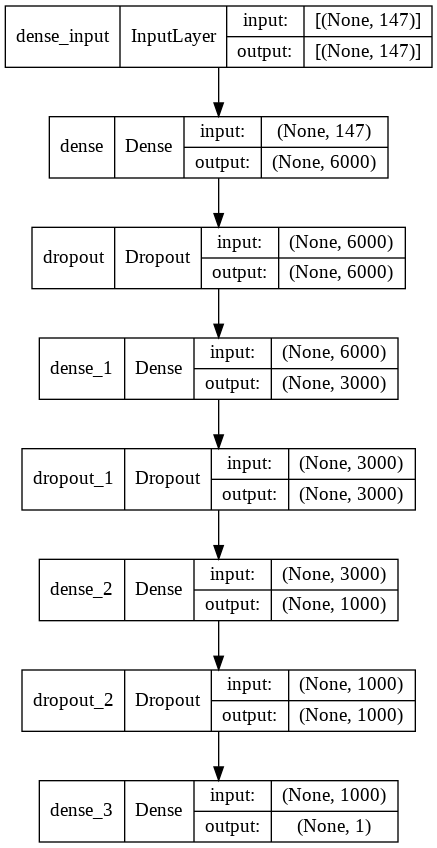

In [ ]:
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
disp_Image(filename=plot_path, width=400, height=400)

In [ ]:
# Obtener varios resultados y juntarlos en una tabla (para comprobar variabilidas¡d/estabilidad del modelo)

In [ ]:
res_LSTM1 = pd.DataFrame([name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test], index=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"]).T

In [ ]:
df_results = pd.DataFrame()

In [ ]:
df_results1 = df_results1.append(res_LSTM1)

In [ ]:
metrics_time_series(y1_train_inv,y1_train_pred_inv)

R2 = 0.9728548263222981
RSME = 11260.667492822367
MAPE = 0.012684849613800621


(0.9728548263222981, 11260.667492822367, 0.012684849613800621)

In [ ]:
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9376906356915515
RSME = 15516.81833739583
MAPE = 0.018334031566212435


(0.9376906356915515, 15516.81833739583, 0.018334031566212435)

R2 = 0.9376906356915515

RSME = 15516.81833739583

MAPE = 0.018334031566212435

(0.9376906356915515, 15516.81833739583, 0.018334031566212435)

In [ ]:
# Define model
model = Sequential()
model.add(Dense(units=6000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(units=3000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(units=1000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(1))

epochs = 100

In [ ]:
#save(filepath, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None, save_traces=True)

In [ ]:
#save_weights(filepath, overwrite=True, save_format=None, options=None)

#### MULTI-TRAIN DE MODELOS: MODELO 1

In [144]:
n_features = X1_train_ts.shape[1]
n_features

147

In [167]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint


def multi_train_model(X_train, X_test, y_test, y_train, sclr_y, epcs=300, btch=1, n_train_models=30):

  clf = pd.DataFrame(columns=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"])

  for i in range(1,n_train_models+1):
    
    name = 'MODEL_MLP - ' + str(i)

    print("Traininig:" + name)     
    #6000 , 3000 , 1000 / 0 , 0 , 0 (0.926)  +300 (0.931 overfitting) +200 (0.911)

    # Define model
    model = Sequential()
    model.add(Dense(units=6000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
    #model.add(Dropout(0))
    model.add(Dense(units=3000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
    #model.add(Dropout(0))
    model.add(Dense(units=1000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
    #model.add(Dropout(0))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')


    # define the checkpoint
    filepath = "/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Train_Modelos/" + name + ".h5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss',  patience=50, verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    #es = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=50, verbose=0, mode='auto')
    #callbacks_list = [es]


    # Fit model
    model.fit(X_train, y_train, epochs=epcs, batch_size=btch, callbacks=callbacks_list, verbose=1)

    # Train prediction
    y_train_pred = model.predict(X_train, verbose=0)
    # Test prediction
    y_test_pred = model.predict(X_test, verbose=0)



    # Scalers (define and applied previously)
    # Undo scaler (invert predictions)
    y_train_inv = sclr_y.inverse_transform(y_train)
    y_train_pred_inv = sclr_y.inverse_transform(y_train_pred)
    # Undo scaler (invert predictions)
    y_test_inv = sclr_y.inverse_transform(y_test)
    y_test_pred_inv = sclr_y.inverse_transform(y_test_pred)


    R2_train, RSME_train, MAPE_train = metrics_time_series(y_train_inv, y_train_pred_inv)
    R2_test, RSME_test, MAPE_test = metrics_time_series(y_test_inv, y_test_pred_inv)

    df_row = [name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test]
    clf.loc[i-1] = df_row

    print(" "*50)
    print("#"*50)

  return clf



In [170]:
resultados1_MLP = multi_train_model(X_train=X1_train_ts, X_test=X1_test_ts, y_test=y1_test_ts, y_train=y1_train_ts, epcs=300, btch=30, n_train_models=50, sclr_y=scaler_y1)
resultados1_MLP

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 262/300
80/86 [==========================>...] - ETA: 0s - loss: 2.2521e-04
Epoch 00262: loss did not improve from 0.00021
86/86 [==============================] - 0s 5ms/step - loss: 2.2454e-04
Epoch 263/300
82/86 [===========================>..] - ETA: 0s - loss: 2.1589e-04
Epoch 00263: loss did not improve from 0.00021
86/86 [==============================] - 0s 5ms/step - loss: 2.1640e-04
Epoch 264/300
85/86 [============================>.] - ETA: 0s - loss: 2.2827e-04
Epoch 00264: loss did not improve from 0.00021
86/86 [==============================] - 0s 5ms/step - loss: 2.2821e-04
Epoch 265/300
81/86 [===========================>..] - ETA: 0s - loss: 2.0240e-04
Epoch 00265: loss improved from 0.00021 to 0.00020, saving model to /content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Train_Modelos/MODEL_MLP - 46.h5
86/86 [==============================] - 1s 17ms/step - loss: 2.0087e-04
Epoch 266/300
79/86 [=======

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,MODEL_MLP - 1,0.992523,5909.906911,0.006423,0.880810,21460.769608,0.024713
1,MODEL_MLP - 2,0.993672,5437.005508,0.006260,0.914568,18169.193021,0.020853
2,MODEL_MLP - 3,0.991266,6387.445386,0.007669,0.901801,19479.621927,0.023070
3,MODEL_MLP - 4,0.995410,4630.514413,0.004869,0.906447,19013.194290,0.021950
4,MODEL_MLP - 5,0.994116,5242.699886,0.005959,0.895953,20051.196781,0.023775
5,MODEL_MLP - 6,0.995648,4508.749285,0.005158,0.905156,19143.907323,0.021765
6,MODEL_MLP - 7,0.994822,4917.938754,0.005465,0.895768,20069.018639,0.023646
7,MODEL_MLP - 8,0.995626,4520.279479,0.005179,0.894505,20190.251761,0.023963
8,MODEL_MLP - 9,0.995210,4730.509520,0.005300,0.896582,19990.481489,0.023273
9,MODEL_MLP - 10,0.991349,6356.992945,0.007474,0.902979,19362.429633,0.022189


In [171]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint

def res_test_modelLSTM(X_train, X_test, y_test, y_train, sclr_y, folder_path, n_train_models=1):

  clf = pd.DataFrame(columns=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"])

  for i in range(1,n_train_models+1):
    
    name = 'MODEL_MLP - ' + str(i)
    filepath = folder_path + name

    # load the model
    model = load_model(filepath)

    # Train prediction
    train_predict = model.predict(X_train, verbose=0)
    # Test prediction
    test_predict = model.predict(X_test, verbose=0)

    #print(train_predict.shape)
    #print(test_predict.shape)
    #print(y_train.shape)
    #print(y_test.shape)
    #print(test_predict[1:10])

    # define scaler
    scaler = sclr_y

    train_predict = train_predict.reshape((train_predict.shape[0], train_predict.shape[1]))
    test_predict = test_predict.reshape((test_predict.shape[0], test_predict.shape[1]))
    #print(test_predict[1:10])

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    #print(y_train.shape)
    #print(y_test.shape)
    train_y = scaler.inverse_transform(y_train)
    test_y = scaler.inverse_transform(y_test)


    R2_train, RSME_train, MAPE_train = metrics_time_series(train_y, train_predict)
    R2_test, RSME_test, MAPE_test = metrics_time_series(test_y, test_predict)

    df_row = [name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test]
    clf.loc[i-1] = df_row

    print(" "*50)
    print("#"*50)

  return clf


In [172]:
resultados1_MLP = res_test_modelLSTM(X_train=X1_train_ts, X_test=X1_test_ts, y_test=y1_test_ts, y_train=y1_train_ts, 
                                     folder_path='/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Train_Modelos/', sclr_y=scaler_y1, n_train_models=50)

R2 = 0.9960875793518271
RSME = 4275.044044900108
MAPE = 0.004630963895860451
R2 = 0.9037390840747337
RSME = 19286.39291533372
MAPE = 0.022771675770032675
                                                  
##################################################
R2 = 0.9904114799514174
RSME = 6692.580639195746
MAPE = 0.008531457678534847
R2 = 0.8909925148664743
RSME = 20523.629951993513
MAPE = 0.024403334369110935
                                                  
##################################################
R2 = 0.9922434962543977
RSME = 6019.367036925144
MAPE = 0.006639019809583236
R2 = 0.8827046604112808
RSME = 21289.54569054536
MAPE = 0.025117409863307016
                                                  
##################################################
R2 = 0.9952208010497813
RSME = 4724.9299839593095
MAPE = 0.005172308648016836
R2 = 0.899870925711392
RSME = 19670.07953349455
MAPE = 0.02302069751531832
                                                  
###########################

In [174]:
resultados1_MLP

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,MODEL_MLP - 1.h5,0.996088,4275.044045,0.004631,0.903739,19286.392915,0.022772
1,MODEL_MLP - 2.h5,0.990411,6692.580639,0.008531,0.890993,20523.629952,0.024403
2,MODEL_MLP - 3.h5,0.992243,6019.367037,0.006639,0.882705,21289.545691,0.025117
3,MODEL_MLP - 4.h5,0.995221,4724.929984,0.005172,0.899871,19670.079533,0.023021
4,MODEL_MLP - 5.h5,0.996194,4216.650744,0.004519,0.906520,19005.767525,0.022760
5,MODEL_MLP - 6.h5,0.996072,4283.345811,0.004643,0.887805,20821.550895,0.023434
6,MODEL_MLP - 7.h5,0.995819,4419.214184,0.004850,0.905053,19154.284050,0.022118
7,MODEL_MLP - 8.h5,0.993412,5547.443703,0.005906,0.881248,21421.329554,0.025188
8,MODEL_MLP - 9.h5,0.996782,3877.412925,0.004123,0.894933,20149.226230,0.023700
9,MODEL_MLP - 10.h5,0.991349,6356.992945,0.007474,0.902979,19362.429633,0.022189


In [177]:
# modified from http://cssmenumaker.com/br/blog/stylish-css-tables-tutorial
css = """
<style type=\"text/css\">
table {
color: #333;
font-family: Helvetica, Arial, sans-serif;
width: 640px;
border-collapse:
collapse; 
border-spacing: 0;
}
td, th {
border: 1px solid transparent; /* No more visible border */
height: 30px;
}
th {
background: #DFDFDF; /* Darken header a bit */
font-weight: bold;
}
td {
background: #FAFAFA;
text-align: center;
}
table tr:nth-child(odd) td{
background-color: white;
}
</style>
"""

In [178]:
data_out = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Resultados1_MLP.csv'       
resultados1_MLP.to_csv(data_out, index=False, encoding="ISO 8859-1")

In [179]:
text_file = open("/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Resultados1_MLP.html", "a")
# write the CSS
text_file.write(css)
# write the HTML-ized Pandas DataFrame
text_file.write(resultados1_MLP.to_html())
text_file.close()

In [183]:
resultados1_MLP_order = resultados1_MLP.sort_values(by='R2_test', ascending=False)
resultados1_MLP_order

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
15,MODEL_MLP - 16.h5,0.995270,4700.608078,0.005221,0.938342,15435.520287,0.018241
24,MODEL_MLP - 25.h5,0.995284,4693.585677,0.005253,0.927888,16692.861555,0.019663
32,MODEL_MLP - 33.h5,0.995974,4336.648584,0.004896,0.924876,17037.830235,0.019821
36,MODEL_MLP - 37.h5,0.993981,5302.547790,0.005472,0.924570,17072.531276,0.019859
26,MODEL_MLP - 27.h5,0.995967,4340.317917,0.004654,0.921757,17387.929086,0.020665
34,MODEL_MLP - 35.h5,0.996136,4248.599263,0.004721,0.921607,17404.637137,0.019616
23,MODEL_MLP - 24.h5,0.993965,5309.691840,0.006146,0.917659,17837.452525,0.020972
27,MODEL_MLP - 28.h5,0.994379,5124.222381,0.005663,0.917244,17882.358966,0.020693
38,MODEL_MLP - 39.h5,0.988345,7378.540204,0.009387,0.916804,17929.880976,0.021400
47,MODEL_MLP - 48.h5,0.995904,4374.169826,0.004725,0.914876,18136.411549,0.021184


In [182]:
data_out = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Resultados1_MLP_order.csv'       
resultados1_MLP_order.to_csv(data_out, index=False, encoding="ISO 8859-1")

In [185]:
name = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Train_Modelos/MODEL_MLP - 15.h5'
filepath = name

# load the model
model = load_model(filepath)

In [147]:
name = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Copia de MODEL_MLP - 1.h5'
filepath = name

# load the model
model = load_model(filepath)

# Train prediction
train_predict = model.predict(X1_train_ts, verbose=0)
# Test prediction
test_predict = model.predict(X1_test_ts, verbose=0)


In [206]:
path_out = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/'

In [207]:
plot_MLP1 = path_out + 'plot_model_MLP1.png'

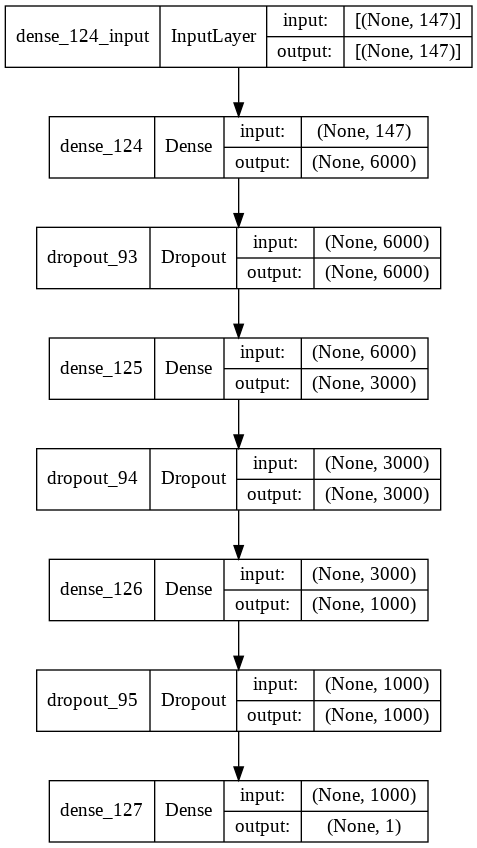

In [208]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=plot_MLP1, show_shapes=True, show_layer_names=True)

In [ ]:
len(y1_test)

365

In [ ]:
metrics_time_series(y1_train_inv,y1_train_pred_inv)
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9897878774434306
RSME = 6906.783319596951
MAPE = 0.007396661304500069


(0.9897878774434306, 6906.783319596951, 0.007396661304500069)

In [ ]:
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9112581118154426
RSME = 18517.8408789761
MAPE = 0.021214094090805054


(0.9112581118154426, 18517.8408789761, 0.021214094090805054)

In [ ]:
'''
# load the model
new_model = load_model(filepath)
assert_allclose(model.predict(x_train), new_model.predict(x_train), 1e-5)

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)
'''

### ANÁLISIS DE RESULTADOS Y VISUALIZACIÓN

#### DATOS GENERALES

In [209]:
date_y = Data_df[['Fecha', 'DemReal']].sort_values(by='Fecha', axis=0, ascending=True, inplace=False, kind='quicksort')
date_y

,Fecha,DemReal
0,2014-01-01,552505.0
1,2014-01-02,676599.0
2,2014-01-03,683165.0
3,2014-01-04,644653.0
4,2014-01-05,608007.0
...,...,...
2917,2021-12-27,614441.0
2918,2021-12-28,621530.0
2919,2021-12-29,615488.0
2920,2021-12-30,614903.0


In [210]:
fechas = Data_df['Fecha']  #.sort_values(axis=0, ascending=True, inplace=False, kind='quicksort')

In [211]:
fechas_train = fechas[:2557].reset_index(drop=True)
fechas_train

0      2014-01-01
1      2014-01-02
2      2014-01-03
3      2014-01-04
4      2014-01-05
          ...    
2552   2020-12-27
2553   2020-12-28
2554   2020-12-29
2555   2020-12-30
2556   2020-12-31
Name: Fecha, Length: 2557, dtype: datetime64[ns]

In [212]:
fechas_test = fechas[2557:].reset_index(drop=True)
fechas_test

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
360   2021-12-27
361   2021-12-28
362   2021-12-29
363   2021-12-30
364   2021-12-31
Name: Fecha, Length: 365, dtype: datetime64[ns]

#### MODELO 1

In [213]:
scaler_y1 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y1.fit(y1_train)

MinMaxScaler()

In [214]:
# demonstrate prediction
y1_train_pred_ts = model.predict(X1_train_ts, verbose=1)

80/80 [==============================] - 0s 1ms/step


In [215]:
# demonstrate prediction
y1_test_pred_ts = model.predict(X1_test_ts, verbose=1)

12/12 [==============================] - 0s 2ms/step


In [216]:
#y1_test_ts
#y1_pred_ts

In [217]:
# Scalers (define and applied previously)
scaler_X1
scaler_y1

# Undo scaler (invert predictions)
y1_train_inv = scaler_y1.inverse_transform(y1_train_ts)
y1_train_pred_inv = scaler_y1.inverse_transform(y1_train_pred_ts)

# Undo scaler (invert predictions)
y1_test_inv = scaler_y1.inverse_transform(y1_test_ts)
y1_test_pred_inv = scaler_y1.inverse_transform(y1_test_pred_ts)

In [218]:
print(len(y1_train_inv))
print(len(y1_train_pred_inv))

2556
2556


In [219]:
print(len(y1_test_inv))
print(len(y1_test_pred_inv))

364
364


In [220]:
#save(filepath, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None, save_traces=True)

In [221]:
#save_weights(filepath, overwrite=True, save_format=None, options=None)

In [222]:
#y1_train_pred_inv = y1_train_pred_inv.drop(columns='Fecha')

In [223]:
y1_train_pred_inv = pd.DataFrame(y1_train_pred_inv)
y1_train_pred_inv = pd.concat([fechas_train, y1_train_pred_inv], axis=1)
y1_train_pred_inv.columns = ['Fecha', 'y1_train_pred_inv']
y1_train_pred_inv

,Fecha,y1_train_pred_inv
0,2014-01-01,678897.3750
1,2014-01-02,683517.6875
2,2014-01-03,641045.8750
3,2014-01-04,612631.0000
4,2014-01-05,574144.5000
...,...,...
2552,2020-12-27,692089.9375
2553,2020-12-28,697036.3750
2554,2020-12-29,700020.2500
2555,2020-12-30,653166.3125


In [224]:
#y1_test_pred_inv = y1_test_pred_inv.drop(columns='Fecha')

In [225]:
y1_test_pred_inv = pd.DataFrame(y1_test_pred_inv)
y1_test_pred_inv = pd.concat([fechas_test, y1_test_pred_inv], axis=1)
y1_test_pred_inv.columns = ['Fecha', 'y1_test_pred_inv']
y1_test_pred_inv

,Fecha,y1_test_pred_inv
0,2021-01-01,647294.1875
1,2021-01-02,653889.7500
2,2021-01-03,751133.5625
3,2021-01-04,743499.3125
4,2021-01-05,672342.0000
...,...,...
360,2021-12-27,644087.3750
361,2021-12-28,666122.9375
362,2021-12-29,658171.6250
363,2021-12-30,601330.4375


In [226]:
import numpy as np # numerical python
import pandas as pd # pannel datasets
import matplotlib.pyplot as plt 
import seaborn as sns

In [227]:
y1_train_pred_inv.shape

(2557, 2)

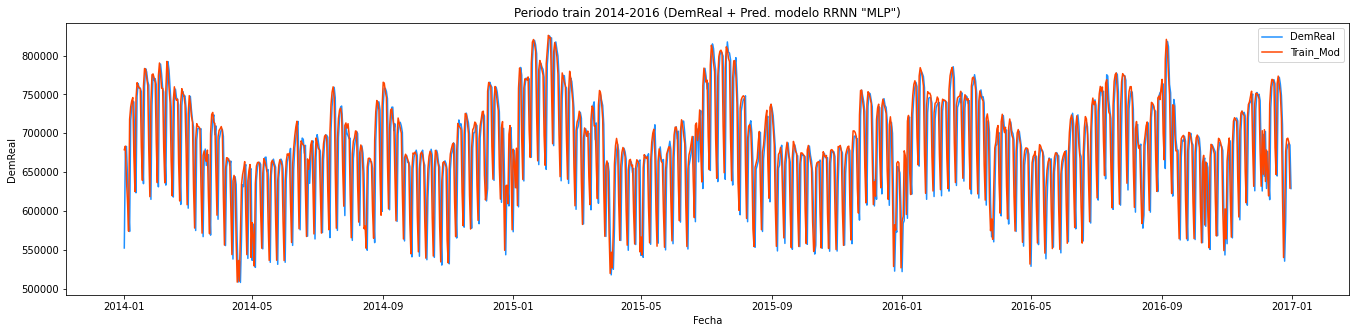

In [238]:
# MODELO 1: Train 2014-2016 (Using Seaborn)

plt.figure(figsize=(23,5))
sns.lineplot(x='Fecha',y='DemReal',data=date_y[:1096], color='dodgerblue', legend='full')
sns.lineplot(x='Fecha',y='y1_train_pred_inv',data=y1_train_pred_inv[:1095], color='orangered')
plt.legend(labels=["DemReal","Train_Mod"])
plt.title(label='Periodo train 2014-2016 (DemReal + Pred. modelo RRNN "MLP")')

plt.savefig('/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Periodo train 2014-2016 (DemReal + Pred. modelo RRNN "MLP").png', dpi=1500)
plt.show()

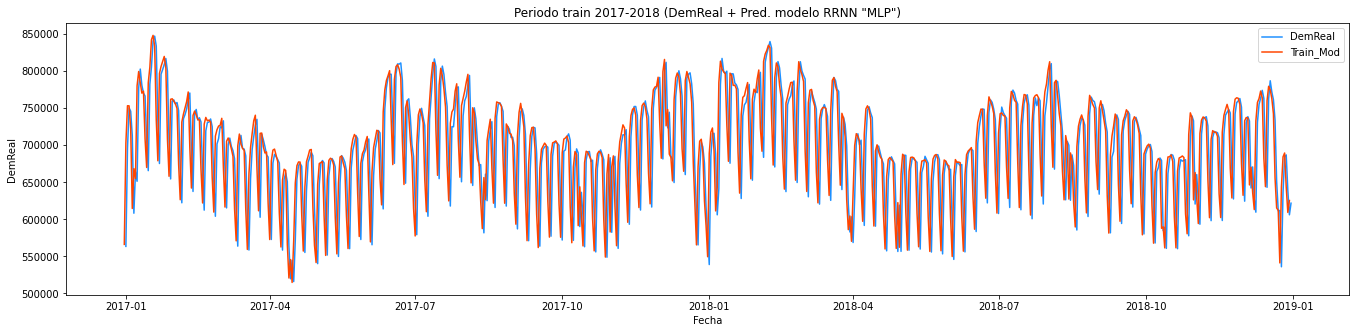

In [240]:
# MODELO 1: Train 2017-2018 (Using Seaborn)

plt.figure(figsize=(23,5))
sns.lineplot(x='Fecha',y='DemReal',data=date_y[1096:1826], color='dodgerblue', legend='full')
sns.lineplot(x='Fecha',y='y1_train_pred_inv',data=y1_train_pred_inv[1095:1825], color='orangered')
plt.legend(labels=["DemReal","Train_Mod"])
plt.title(label='Periodo train 2017-2018 (DemReal + Pred. modelo RRNN "MLP")')

plt.savefig('/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Periodo train 2017-2018 (DemReal + Pred. modelo RRNN "MLP").png', dpi=1500)
plt.show()

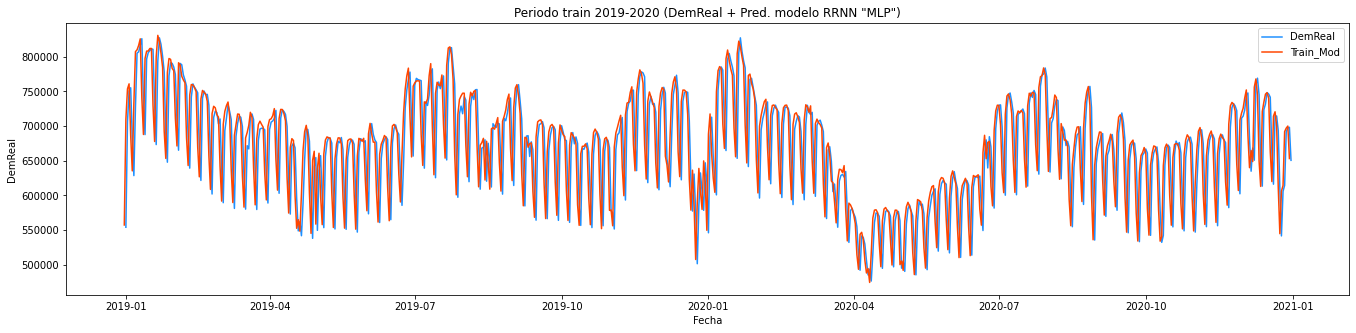

In [241]:
# MODELO 1: Train 2019-2020 (Using Seaborn)

plt.figure(figsize=(23,5))
sns.lineplot(x='Fecha',y='DemReal',data=date_y[1826:2557], color='dodgerblue', legend='full')
sns.lineplot(x='Fecha',y='y1_train_pred_inv',data=y1_train_pred_inv[1825:2556], color='orangered')
plt.legend(labels=["DemReal","Train_Mod"])
plt.title(label='Periodo train 2019-2020 (DemReal + Pred. modelo RRNN "MLP")')

plt.savefig('/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Periodo train 2019-2020 (DemReal + Pred. modelo RRNN "MLP").png', dpi=1500)
plt.show()

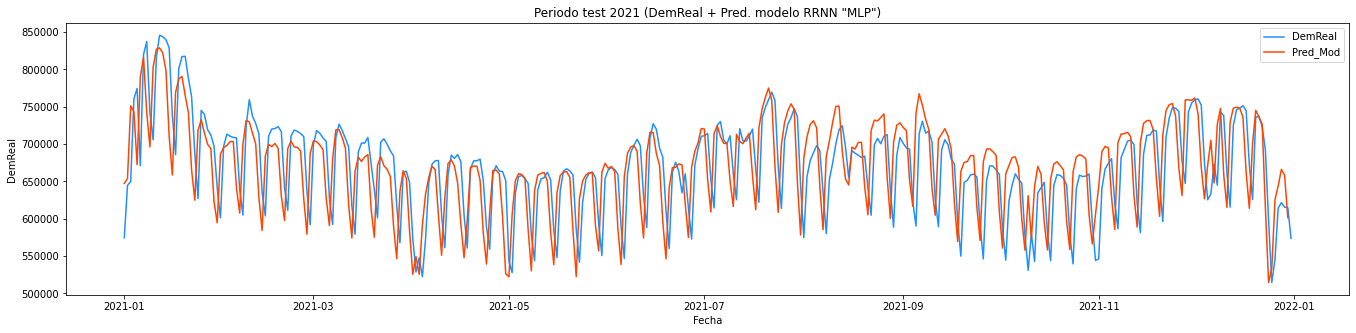

In [242]:
# MODELO 1: Pred. "test" (Using Seaborn)

plt.figure(figsize=(23,5))
sns.lineplot(x='Fecha',y='DemReal',data=date_y[2557:], color='dodgerblue', legend='full')
sns.lineplot(x='Fecha',y='y1_test_pred_inv',data=y1_test_pred_inv, color='orangered')
plt.legend(labels=["DemReal","Pred_Mod"])
plt.title(label='Periodo test 2021 (DemReal + Pred. modelo RRNN "MLP")')

plt.savefig('/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Periodo test 2021 (DemReal + Pred. modelo RRNN "MLP").png', dpi=1500)
plt.show()


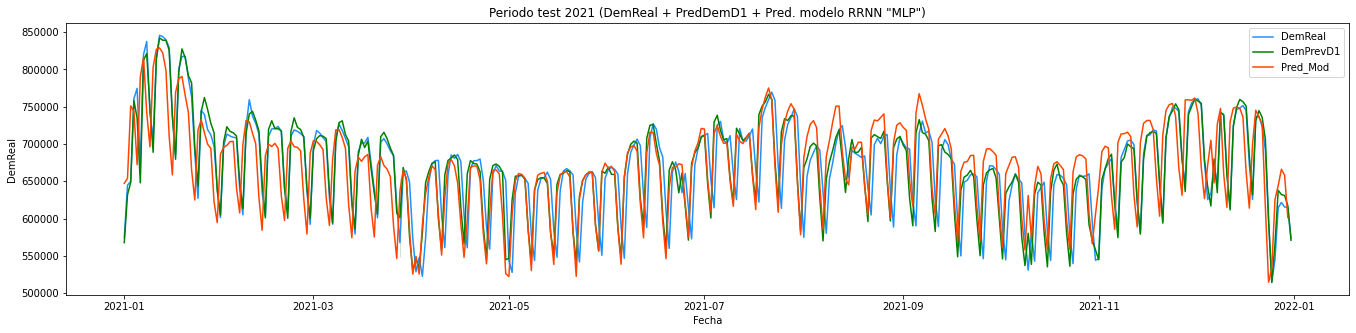

In [243]:
# MODELO 1: Pred. "test" (Using Seaborn)

plt.figure(figsize=(23,5))
sns.lineplot(x='Fecha',y='DemReal',data=date_y[2557:], color='dodgerblue', legend='full')
sns.lineplot(x='Fecha',y='DemPrevD1',data=DemPrevD1_df[731:], color='green', legend='full')
sns.lineplot(x='Fecha',y='y1_test_pred_inv',data=y1_test_pred_inv, color='orangered')
plt.legend(labels=["DemReal", "DemPrevD1", "Pred_Mod"])
plt.title(label='Periodo test 2021 (DemReal + PredDemD1 + Pred. modelo RRNN "MLP")')

plt.savefig('/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/MLP/Periodo test 2021 (DemReal + PredDemD1 + Pred. modelo RRNN "MLP").png', dpi=1500)
plt.show()


In [ ]:
'''
3. Time Series Box and Whisker Plots by Interval
Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval.

Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

Box and whisker plots can be created and compared for each interval in a time series, such as years, months, or days.

Below is an example of grouping the Minimum Daily Temperatures dataset by years, as was done above in the plot example. A box and whisker plot is then created for each year and lined up side-by-side for direct comparison.

from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

'''

In [ ]:
'''

Then, the observations are grouped by month, and each month is added to a new DataFrame as a column.

Finally, a box and whisker plot is created for each month-column in the newly constructed DataFrame.

# create a boxplot of monthly data
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from pandas import concat
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
one_year = series['1990']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
months.boxplot()
pyplot.show()
Running the example creates 12 box and whisker plots, showing the significant change in distribution of minimum temperatures across the months of the year from the Southern Hemisphere summer in January to the Southern Hemisphere winter in the middle of the year, and back to summer again.

'''

In [ ]:
'''


4. Time Series Heat Maps

from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto')
pyplot.show()



from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from pandas import concat
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
one_year = series['1990']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
pyplot.matshow(months, interpolation=None, aspect='auto')
pyplot.show()
Running the example shows the same macro trend seen for each year on the zoomed level of month-to-month.

'''

In [ ]:
'''

5. Time Series Lag Scatter Plots

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
values = DataFrame(series.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()
Running the example suggests the strongest relationship between an observation with its lag1 value, but generally a good positive correlation with each value in the last week.

'''

In [ ]:
'''

6. Time Series Autocorrelation Plots

# create an autocorrelation plot
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
autocorrelation_plot(series)
pyplot.show()

'''

### RESULTADOS GUARDADOS

In [ ]:
metrics_time_series(y1_train_inv,y1_train_pred_inv)

R2 = 0.9728548263222981
RSME = 11260.667492822367
MAPE = 0.012684849613800621


(0.9728548263222981, 11260.667492822367, 0.012684849613800621)

In [ ]:
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9376906356915515
RSME = 15516.81833739583
MAPE = 0.018334031566212435


(0.9376906356915515, 15516.81833739583, 0.018334031566212435)

R2 = 0.9376906356915515

RSME = 15516.81833739583

MAPE = 0.018334031566212435

(0.9376906356915515, 15516.81833739583, 0.018334031566212435)

In [ ]:
# Define model
model = Sequential()
model.add(Dense(units=6000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(units=3000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(units=1000, input_dim=n_features, activation='relu', kernel_initializer=HeUniform()))
model.add(Dropout(0.05))
model.add(Dense(1))

In [ ]:
#save(filepath, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None, save_traces=True)

In [ ]:
#save_weights(filepath, overwrite=True, save_format=None, options=None)

In [ ]:
y1_test_pred_inv = pd.DataFrame(y1_test_pred_inv)
y1_test_pred_inv = pd.concat([fechas_test, y1_test_pred_inv], axis=1)
y1_test_pred_inv.columns = ['Fecha', 'y1_test_pred_inv']
y1_test_pred_inv

,Fecha,y1_test_pred_inv
0,2021-01-01,647322.4375
1,2021-01-02,646650.8125
2,2021-01-03,777821.4375
3,2021-01-04,751161.7500
4,2021-01-05,691613.5000
...,...,...
360,2021-12-27,636716.0000
361,2021-12-28,646743.4375
362,2021-12-29,642154.7500
363,2021-12-30,592356.4375


In [ ]:
#y1_pred_inv = y1_pred_inv.drop(columns='Fecha')

In [ ]:
import numpy as np # numerical python
import pandas as pd # pannel datasets
import matplotlib.pyplot as plt 
import seaborn as sns

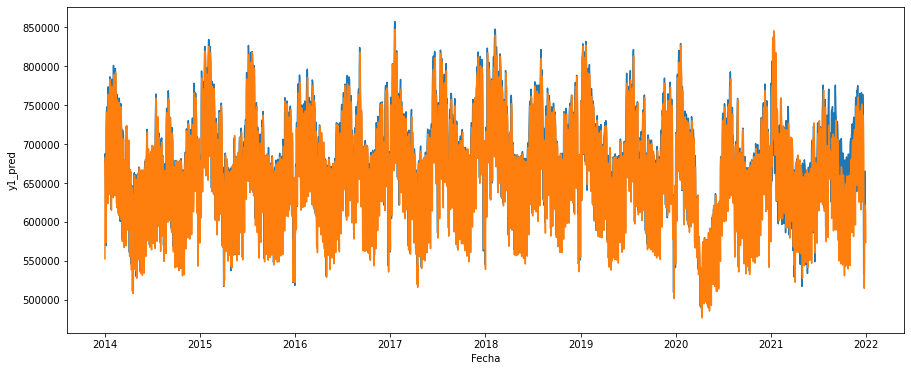

In [ ]:
# MODELO 1: Pred. completa (Using Seaborn)

plt.figure(figsize=(15,6))
sns.lineplot(x='Fecha',y='y1_pred',data=date_y1_pred, legend='full')
sns.lineplot(x='Fecha',y='DemReal',data=date_y, palette='red', legend='full')
plt.show()

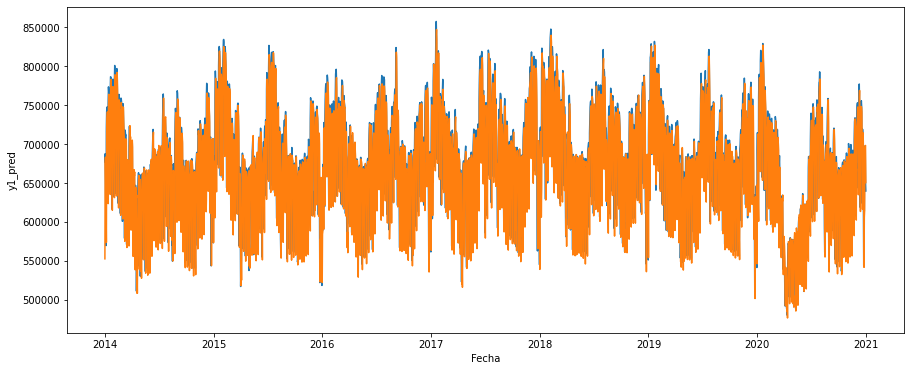

In [ ]:
# MODELO 1: Pred. "train" (Using Seaborn)

plt.figure(figsize=(15,6))
sns.lineplot(x='Fecha',y='y1_pred',data=date_y1_pred[:2557])
sns.lineplot(x='Fecha',y='DemReal',data=date_y[:2557], palette='red', legend='full')
plt.show()

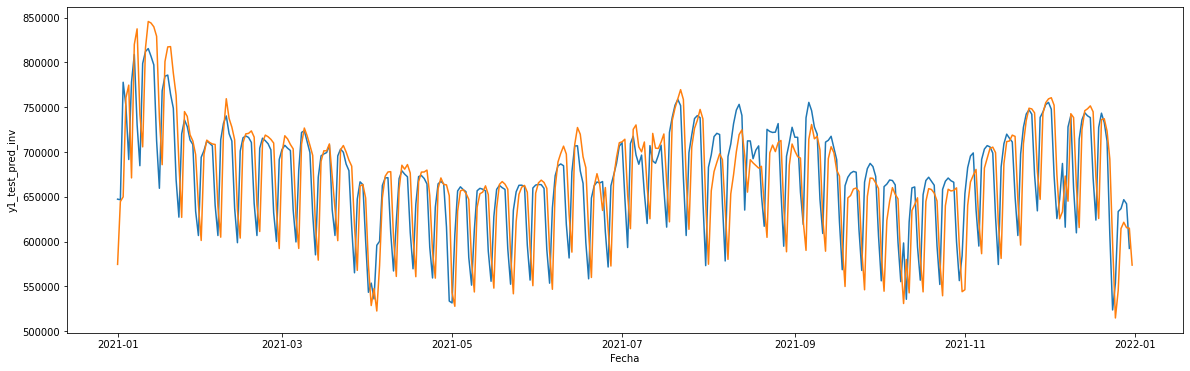

In [ ]:
# MODELO 1: Pred. "test" (Using Seaborn)

plt.figure(figsize=(20,6))
sns.lineplot(x='Fecha',y='y1_test_pred_inv',data=y1_test_pred_inv)
sns.lineplot(x='Fecha',y='DemReal',data=date_y[2557:], palette='red', legend='full')
plt.show()

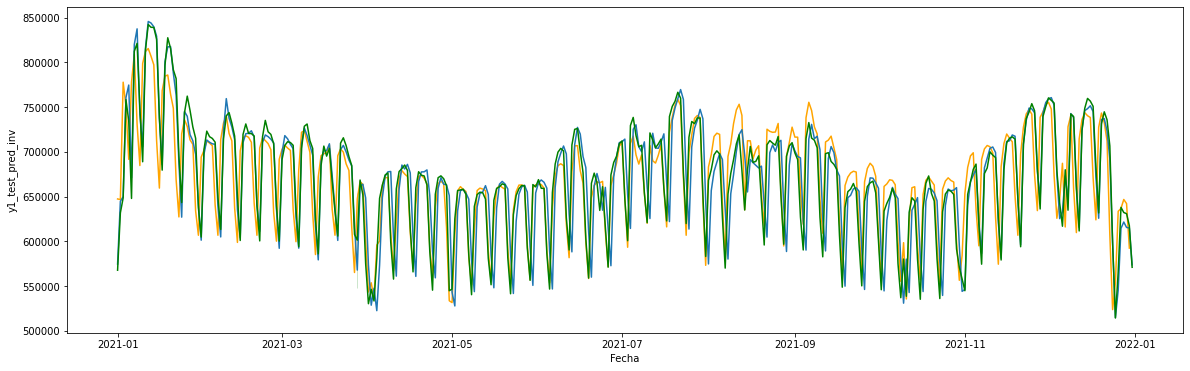

In [ ]:
# MODELO 1: Pred. "test" (Using Seaborn)

plt.figure(figsize=(20,6))
sns.lineplot(x='Fecha',y='y1_test_pred_inv',data=y1_test_pred_inv, color='orange')
sns.lineplot(x='Fecha',y='DemReal',data=date_y[2557:], legend='full')
sns.lineplot(x='Fecha',y='DemPrevD1',data=DemPrevD1_df[731:], color='green', legend='full')
plt.show()

### DESCARTADO

#### GRIDSEARCH

In [ ]:
n_features1 = X1_train_ts.shape[1]
n_features1

147

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping


# Function to create model, required for KerasClassifier
def create_model(unit_md1,unit_md2,ker_init,drp1,drp2,unit_md3,drp3):  #unit_md3,drp3,ker_init
  # Define model
  model = Sequential()
  model.add(Dense(units=unit_md1, input_dim=n_features1, activation='relu', kernel_initializer=ker_init))
  model.add(Dropout(drp1))
  model.add(Dense(units=unit_md2, input_dim=n_features1, activation='relu', kernel_initializer=ker_init))
  model.add(Dropout(drp2))
  model.add(Dense(units=unit_md3, input_dim=n_features, activation='relu', kernel_initializer=ker_init))
  model.add(Dropout(drp3))
  model.add(Dense(1))
  # Compile model
  #model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Random seed for reproducibility (already fixed in enviroment)

# load dataset
# split into input (X) and output (Y) variables
X1_train_ts
y1_train_ts
X1_test_ts
y1_test_ts

# create model
predictor = KerasRegressor(model=create_model, optimizer='adam', loss='mean_squared_error', warm_start=False, batch_size=None)
#ker_init
# define pipeline, grid search parameters, cv parameter and scorers
steps = [('predictor', predictor)]
pipe = Pipeline(steps)

param_grid = {
    'predictor__model__unit_md1': [7000],
    'predictor__model__unit_md2': [5000],
    'predictor__model__unit_md3': [1000],
    'predictor__model__ker_init': ['he_uniform'],  # 'uniform', 'zeros', 'normal', 'he_normal'
    'predictor__model__drp1': [0.15],
    'predictor__model__drp2': [0.10],
    'predictor__model__drp3': [0.05],
    #'predictor__optimizer':['Adam'],   #'RMSprop', 'Adam', 'Adamax', 'sgd'
    'predictor__batch_size':[1],
    'predictor__epochs':[500]
}

#tscv = TimeSeriesSplit(n_splits=23)   # n_splits=48, n_splits=2, test_size=1
#my_cv = [(X1_train_ts,X1_test_ts) for X1_train_ts, X1_test_ts in tscv.split(X1_train_ts)]

scorers = {'R2':'r2', 'RMSE':'neg_root_mean_squared_error', 'MAPE':'neg_mean_absolute_percentage_error'}


# define GridSearch
clf_MLP1 = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorers, refit='R2', n_jobs=-1, cv=6, verbose=10)   #cv=my_cv
clf_result_MLP1 = clf_MLP1.fit(X1_train_ts, y1_train_ts)  #, callbacks=[es]

# CAMBIAR EL NOMBREDE LA VARIABLE PARA GUARDARLA

Fitting 6 folds for each of 1 candidates, totalling 6 fits


KeyboardInterrupt: ignored

In [ ]:
clf_result_MLP1.best_params_

0.87

{'predictor__epochs': 50,
 'predictor__model__drp1': 0,
 'predictor__model__drp2': 0,
 'predictor__model__ker_init': 'he_uniform',
 'predictor__model__unit_md1': 6000,
 'predictor__model__unit_md2': 3000}

In [ ]:
clf_result_MLP1.best_score_

In [ ]:
predictor.get_params().keys()


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [ ]:
# summarize results
print("Best: %f using %s" % (clf_result.best_score_, clf_result.best_params_))
means = clf_result.cv_results_['mean_test_score']
stds = clf_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.751623 using {'predictor__epochs': 50, 'predictor__model__drp1': 0.05, 'predictor__model__drp2': 0.05, 'predictor__model__ker_init': 'he_uniform', 'predictor__model__unit_md1': 8000, 'predictor__model__unit_md2': 2500}


KeyError: ignored

### Multiple model implementation:
###SimpleRNN, LSTM, GRU, StackedLSTM,  BidirectionalLSTM and StackedBidirectionalLSTM

RNNs:
You can implement easily the RNN family with Keras in few lines of code. Here you can use this function which will configure your RNN. You need to first import the different models from Keras like:

In [ ]:
# import some packages
import tensorflow as tf
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Conv1D, MaxPooling1D, Dropout
from keras.utils.vis_utils import plot_model

Now, we have the models imported from Keras. The function below can generate a simple model (SimpleRNN, LSTM, GRU). Or, two models (identical) can be stacked, or used in Bidirectional or a stack of two Bidirectional models. You can also add the CNN part (Conv1D)with MaxPooling1D and dropout.

In [ ]:
def time_series_deep_learning(x_train, y_train, x_test, y_test, scaler_fit_ydata, plot_path, n_input=1, look_back=1, unit_md1=5000, unit_md2=3000,
                              drp1=0, drp2=0, epcs=100, btch=30, model_dl=LSTM, cnn=False, bidirection=False, stacked=False):    # unit_dense=24,unit_md2=16,unit_md1=32,
    '''
    Generate RNN models with different combinations. Can be simple, stacked or bidirectional. Models can also be used with a CNN part. 
    @param x_train: (matrix) x training data with dimension (samples, time steps, features)
    @param y_train: (list) predict data 
    @param x_test: (matrix) x testing data with dimension (samples, time steps, features)
    @param y_test: (list) predict data 
    @param model_dl: (model) rnn type model (LSTM, GRU) default LSTM
    @param unit: (int) number of cells of the RNN default 4
    @param look_back: (int) number of values in x list, configure the shape of the RNN
    @param cnn: (bool) add cnn part of the model default false
    @param bidirection: (bool) add bidirectional model for the RNN default false
    @param stacked: (bool) stacked two layers of RNN models default false
    @return train_predict: (list) predicted values of x_train
    @return train_y: (list) real y values 
    @return test_predict: (list) predicted test values of x_test
    @return test_y: (list) real test values
    @return (dataframe) containing the name of the model and the metrics
    '''
    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto'
    )
    
    # instance of a Sequential model
    model = Sequential()

    if cnn: # test if cnn part is needed 
        print("CNN")
        model.add(Conv1D(128, 5, activation='relu'))   # HeUniform(seed=314)
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.2))
    
    if not bidirection and not stacked: # test if simple model is needed
        print(f"Simple Model ({model_dl})")
        name = model_dl.__name__
        model.add(model_dl(unit_md1, dropout=drp1, input_shape=(look_back, n_input) ))   #, return_sequences=True
        #model.add(Dropout(drp1))  
        #model.add(model_dl(unit_md2, dropout=drp2,  input_shape=(look_back, n_input)))
        #model.add(Dropout(drp2))

    elif not bidirection: # test if bidirectional  model is needed
        print("Stacked Model")
        name = "Stacked_"+model_dl.__name__
        model.add(model_dl(unit_md1, dropout=drp1,  input_shape=(look_back, n_input), return_sequences=True))
        #model.add(Dropout(drp1))
        model.add(model_dl(unit_md2, dropout=drp2,  input_shape=(look_back, n_input)))
        #model.add(Dropout(drp2))

    elif not stacked: # test if stacked models are needed
        print("Bidirectional Model")
        name = "Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit_md1, dropout=drp1,  input_shape=(look_back, n_input), return_sequences=True)))
        #model.add(Dropout(drp1))
        #model.add(Bidirectional(model_dl(unit_md2, dropout=drp2,  input_shape=(look_back, n_input))))
        #model.add(Dropout(drp2))

    else: # test if bidirectional and stacked models are needed
        print("Stacked Bidirectional Model")
        name = "Stacked_Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit_md1, dropout=drp1,  input_shape=(look_back, n_input), return_sequences=True)))
        #model.add(Dropout(drp1))
        model.add(Bidirectional(model_dl(unit_md2, dropout=drp2,  input_shape=(look_back, n_input))))
        #model.add(Dropout(drp2))

    if cnn: # update name with cnn part 
        name = "CNN_"+name
    
    # add Dense layer with one layer and activation function linear to predict continuous values
    #model.add(Dense(units=unit_dense, activation='relu', kernel_initializer='normal'))
    #model.add(Dropout(0.10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss but can be replace by 'mean_absolute_error'
    
    model.fit(x_train, y_train, epochs=epcs, batch_size=btch, callbacks=[es], verbose=0) #, shuffle=False
    plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
    
    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    print(train_predict.shape)
    print(test_predict.shape)
    print(y_train.shape)
    print(y_test.shape)
    #print(test_predict[1:10])

    # define scaler
    scaler = scaler_fit_ydata

    train_predict = train_predict.reshape((train_predict.shape[0], train_predict.shape[1]))
    test_predict = test_predict.reshape((test_predict.shape[0], test_predict.shape[1]))
    #print(test_predict[1:10])

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
    #print(y_train.shape)
    #print(y_test.shape)
    train_y = scaler.inverse_transform(y_train)
    test_y = scaler.inverse_transform(y_test)
        
    #y_train_nts

    # compute the metrics 
    print("Train")
    R2_train, RSME_train, MAPE_train = metrics_time_series(train_y, train_predict)

    print("Test")
    R2_test, RSME_test, MAPE_test = metrics_time_series(test_y, test_predict)
    
    return train_predict, train_y, test_predict, test_y, pd.DataFrame([name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test], index=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"]).T


This function computes the metrics for the training part and the test part and returned the results in a data frame. Look at how you how to use it for five examples.

In [ ]:
path_out = '/content/drive/MyDrive/TFM/Data_out/'

#### MODELO 1 (sin var. 'DemPrevD1')

In [ ]:
df_results1 = pd.DataFrame()

In [ ]:
scaler_y1 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y1.fit(y1_train)

MinMaxScaler()

In [ ]:
print(X1_train_3D.shape)
print(X1_test_3D.shape)

print(y1_train_3D.shape)
print(y1_test_3D.shape)

(2556, 1, 147)
(364, 1, 147)
(2556, 1, 1)
(364, 1, 1)


##### LSTM:

In [ ]:
plot_LSTM1 = path_out + 'plot_model_LSTM1.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_LSTM1, y_train_LSTM1, x_test_predict_LSTM1, y_test_LSTM1, res_LSTM1 = time_series_deep_learning(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D, scaler_fit_ydata=scaler_y1, 
                                                                                                                n_input=147, look_back=1, unit_md1=1000, drp1=0, #unit_md2=1000, drp2=0,
                                                                                                                epcs=100, btch=7, model_dl=LSTM, plot_path=plot_LSTM1)

Simple Model (<class 'keras.layers.recurrent_v2.LSTM'>)
(2556, 1)
(364, 1)
(2556, 1, 1)
(364, 1, 1)
[[0.49752334]
 [0.8592526 ]
 [0.8004601 ]
 [0.5889635 ]
 [0.87522817]
 [0.93474543]
 [0.7616199 ]
 [0.60967255]
 [0.9373795 ]]
Train
R2 = 0.9687344295820149
RSME = 12085.120932717326
MAPE = 0.013573343905827134
Test
R2 = 0.9340955522810208
RSME = 15958.180680579384
MAPE = 0.019636220118184767


In [ ]:
'''

# 1000 / btc=7
R2 = 0.9687344295820149
RSME = 12085.120932717326
MAPE = 0.013573343905827134
Test
R2 = 0.9340955522810208
RSME = 15958.180680579384
MAPE = 0.019636220118184767



# 




'''

In [ ]:
res_LSTM1

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,LSTM,0.920694,20323.4,0.0242553,0.330737,50757,0.0689087


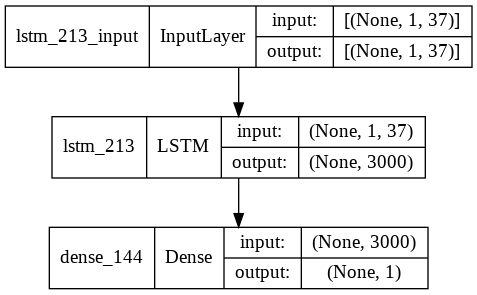

In [ ]:
disp_Image(filename=plot_LSTM1, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results1 = df_results1.append(res_LSTM1)

##### GRU:

In [ ]:
plot_GRU1 = path_out + 'plot_model_GRU1.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_GRU1, y_train_GRU1, x_test_predict_GRU1, y_test_GRU1, res_GRU1 = time_series_deep_learning(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D, scaler_fit_ydata=scaler_y1, 
                                                                                                           n_input=147, look_back=1, unit_md1=1000, drp1=0, #unit_md2=2500, drp2=0.05, 
                                                                                                           epcs=100, btch=7, model_dl=GRU, plot_path=plot_GRU1)

Simple Model (<class 'keras.layers.recurrent_v2.GRU'>)
(2556, 1)
(364, 1)
(2556, 1, 1)
(364, 1, 1)
[[0.49389637]
 [0.8441549 ]
 [0.80249286]
 [0.5571507 ]
 [0.90246195]
 [0.9121835 ]
 [0.7166884 ]
 [0.5842525 ]
 [0.94478905]]
Train
R2 = 0.9737436582093302
RSME = 11074.775492373956
MAPE = 0.01201607000174414
Test
R2 = 0.9109268522906285
RSME = 18552.37078048824
MAPE = 0.021720504984720605


In [ ]:
res_GRU1

In [ ]:
disp_Image(filename=plot_GRU1, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results1 = df_results1.append(res_GRU1)

##### Stack LSTM:

In [ ]:
plot_StLSTM1 = path_out + 'plot_model_StLSTM1.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_StLSTM1, y_train_StLSTM1,x_test_predict_StLSTM1, y_test_StLSTM1, res_StLSTM1 = time_series_deep_learning(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D, 
                                                                                                                         scaler_fit_ydata=scaler_y1, n_input=147, look_back=1, epcs=100, btch=7,
                                                                                                                         unit_md1=3000, drp1=0, unit_md2=1000, drp2=0, 
                                                                                                                         model_dl=LSTM, stacked=True, plot_path=plot_StLSTM1)

Stacked Model
(2556, 1)
(364, 1)
(2556, 1, 1)
(364, 1, 1)
[[0.5203405 ]
 [0.8593271 ]
 [0.78147733]
 [0.58807063]
 [0.8714106 ]
 [0.9235583 ]
 [0.7500204 ]
 [0.6238879 ]
 [0.9260121 ]]
Train
R2 = 0.9750360483193242
RSME = 10798.774915751972
MAPE = 0.011954311273252643
Test
R2 = 0.9376627483712817
RSME = 15520.290320143644
MAPE = 0.019344806575921705


In [ ]:
res_StLSTM1

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,Stacked_LSTM,0.975036,10798.8,0.0119543,0.937663,15520.3,0.0193448


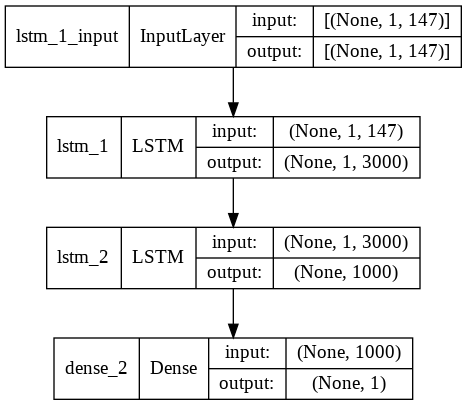

In [ ]:
disp_Image(filename=plot_StLSTM1, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results1 = df_results1.append(res_StLSTM1)

##### Bidirectional LSTM:

In [ ]:
plot_BdLSTM1 = path_out + 'plot_model_BdLSTM1.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_BdLSTM1, y_train_BdLSTM1, x_test_predict_BdLSTM1, y_test_BdLSTM1, res_BdLSTM1 = time_series_deep_learning(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D,
                                                                                                                          scaler_fit_ydata=scaler_y1, n_input=147, look_back=1, epcs=100, btch=7, 
                                                                                                                          unit_md1=3000, drp1=0, unit_md2=1000, drp2=0, 
                                                                                                                          model_dl=LSTM, bidirection=True, plot_path=plot_BdLSTM1)

Bidirectional Model
(2556, 1, 1)
(364, 1, 1)
(2556, 1, 1)
(364, 1, 1)
[[[0.51228166]]

 [[0.8720706 ]]

 [[0.7838529 ]]

 [[0.56669754]]

 [[0.86086434]]

 [[0.9686306 ]]

 [[0.8070905 ]]

 [[0.6523433 ]]

 [[0.96492755]]]
Train
R2 = 0.9712700277889817
RSME = 11584.716903159873
MAPE = 0.013058279309783703
Test
R2 = 0.9228518051146934
RSME = 17265.887222530146
MAPE = 0.021250257492657347


In [ ]:
res_BdLSTM1

In [ ]:
disp_Image(filename=plot_BdLSTM1, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results1 = df_results1.append(res_BdLSTM1)

In [ ]:
(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D, 
scaler_fit_ydata=scaler_y1, n_input=147, look_back=1, epcs=100, btch=7,
unit_md1=3000, drp1=0, unit_md2=1000, drp2=0, 
model_dl=LSTM, stacked=True, plot_path=plot_StLSTM1)

### PRUEBA MODELO LSTM "STACK"

In [ ]:
scaler_y1 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y1.fit(y1_train)

MinMaxScaler()

In [ ]:
print(X1_train_3D.shape)
print(X1_test_3D.shape)

print(y1_train_3D.shape)
print(y1_test_3D.shape)

(2556, 1, 147)
(364, 1, 147)
(2556, 1, 1)
(364, 1, 1)


In [ ]:
# import some packages
import tensorflow as tf
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Conv1D, MaxPooling1D, Dropout
from keras.utils.vis_utils import plot_model

In [ ]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint


def multi_train_modelLSTM(X_train, X_test, y_test, y_train, sclr_y, look_back, n_input, epcs=100, btch=7, n_train_models=1, model_dl=LSTM, unit_md1=6000, unit_md2=3000, unit_md3=1000, drp1=0, drp2=0, drp3=0):

  clf = pd.DataFrame(columns=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"])

  for i in range(1,n_train_models+1):
    
    name = 'MODEL_LSTM - ' + str(i)

    print("Traininig:" + name)     
    #6000 , 3000 , 1000 / 0 , 0 , 0 (0.926)  +300 (0.931 overfitting) +200 (0.911)


    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto'
    )
    
    # instance of a Sequential model
    model = Sequential()

    
    print("LSTM Stacked Model")
    model.add(model_dl(unit_md1, dropout=drp1,  input_shape=(look_back, n_input), return_sequences=True))
    model.add(model_dl(unit_md2, dropout=drp2,  input_shape=(look_back, n_input), return_sequences=True))
    model.add(model_dl(unit_md3, dropout=drp3,  input_shape=(look_back, n_input)))

    # add Dense layer with one layer and activation function linear to predict continuous values
    #model.add(Dense(units=unit_dense, activation='relu', kernel_initializer='normal'))
    #model.add(Dropout(0.10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss but can be replace by 'mean_absolute_error'


    # define the checkpoint
    filepath = "/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Modelos_Train/" + name + ".h5"  #"/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Modelos_Train/" +
    checkpoint = ModelCheckpoint(filepath, monitor='loss',  patience=50, verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    #es = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=50, verbose=0, mode='auto')
    #callbacks_list = [es]


    # Fit model
    model.fit(X_train, y_train, epochs=epcs, batch_size=btch, callbacks=callbacks_list, verbose=1)


    # Train prediction
    train_predict = model.predict(X_train, verbose=0)
    # Test prediction
    test_predict = model.predict(X_test, verbose=0)

    #print(train_predict.shape)
    #print(test_predict.shape)
    #print(y_train.shape)
    #print(y_test.shape)
    #print(test_predict[1:10])

    # define scaler
    scaler = sclr_y

    train_predict = train_predict.reshape((train_predict.shape[0], train_predict.shape[1]))
    test_predict = test_predict.reshape((test_predict.shape[0], test_predict.shape[1]))
    #print(test_predict[1:10])

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
    #print(y_train.shape)
    #print(y_test.shape)
    train_y = scaler.inverse_transform(y_train)
    test_y = scaler.inverse_transform(y_test)


    R2_train, RSME_train, MAPE_train = metrics_time_series(train_y, train_predict)
    R2_test, RSME_test, MAPE_test = metrics_time_series(test_y, test_predict)

    df_row = [name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test]
    clf.loc[i-1] = df_row

    print(" "*50)
    print("#"*50)

  return clf



In [ ]:
'''
epcs=25 / drp=0
R2 = 0.965258108879858
RSME = 12739.270221857449
MAPE = 0.014173298580213883
R2 = 0.9408470366552825
RSME = 15118.693699498584
MAPE = 0.017378654105916734
'''

In [ ]:
resultados1_LSTM = multi_train_modelLSTM(X_train=X1_train_3D, X_test=X1_test_3D, y_test=y1_test_3D, y_train=y1_train_3D, epcs=25, btch=7, n_train_models=50, 
                                         sclr_y=scaler_y1, unit_md1=200, unit_md2=100, unit_md3=50, drp1=0, drp2=0, drp3=0, look_back=1, n_input=147, model_dl=LSTM)

Traininig:MODEL_LSTM - 1
LSTM Stacked Model
Epoch 1/25
362/366 [============================>.] - ETA: 0s - loss: 0.0196
Epoch 00001: loss improved from inf to 0.01956, saving model to /content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Modelos_Train/MODEL_LSTM - 1.h5
366/366 [==============================] - 6s 6ms/step - loss: 0.0196
Epoch 2/25
366/366 [==============================] - ETA: 0s - loss: 0.0052
Epoch 00002: loss improved from 0.01956 to 0.00518, saving model to /content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Modelos_Train/MODEL_LSTM - 1.h5
366/366 [==============================] - 3s 8ms/step - loss: 0.0052
Epoch 3/25
362/366 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 00003: loss improved from 0.00518 to 0.00460, saving model to /content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Modelos_Train/MODEL_LSTM - 1.h5
366/366 [==============================] - 3s 8ms/step - loss: 0.0046
Epoch 4/25
359/366 [============================>.] - ETA: 0s - loss: 0.

In [ ]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.initializers import HeUniform
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint

def res_test_modelLSTM(X_train, X_test, y_test, y_train, sclr_y, folder_path, n_train_models=1):

  clf = pd.DataFrame(columns=["Name", "R2_train", "RSME_train", "MAPE_train", "R2_test", "RSME_test", "MAPE_test"])

  for i in range(1,n_train_models+1):
    
    name = 'MODEL_LSTM - ' + str(i) + '.h5'
    filepath = folder_path + name

    # load the model
    model = load_model(filepath)

    # Train prediction
    train_predict = model.predict(X_train, verbose=0)
    # Test prediction
    test_predict = model.predict(X_test, verbose=0)

    #print(train_predict.shape)
    #print(test_predict.shape)
    #print(y_train.shape)
    #print(y_test.shape)
    #print(test_predict[1:10])

    # define scaler
    scaler = sclr_y

    train_predict = train_predict.reshape((train_predict.shape[0], train_predict.shape[1]))
    test_predict = test_predict.reshape((test_predict.shape[0], test_predict.shape[1]))
    #print(test_predict[1:10])

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
    #print(y_train.shape)
    #print(y_test.shape)
    train_y = scaler.inverse_transform(y_train)
    test_y = scaler.inverse_transform(y_test)


    R2_train, RSME_train, MAPE_train = metrics_time_series(train_y, train_predict)
    R2_test, RSME_test, MAPE_test = metrics_time_series(test_y, test_predict)

    df_row = [name, R2_train, RSME_train, MAPE_train, R2_test, RSME_test, MAPE_test]
    clf.loc[i-1] = df_row

    print(" "*50)
    print("#"*50)

  return clf


In [ ]:
resultados1_LSTM = res_test_modelLSTM(X_train=X1_train_3D, X_test=X1_test_3D, y_test=y1_test_3D, y_train=y1_train_3D, 
                                      folder_path='/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/LSTM/Modelos_Train/', sclr_y=scaler_y1, n_train_models=50) #LSTM/

R2 = 0.9756958743421863
RSME = 10655.10719740612
MAPE = 0.011461635722865376
R2 = 0.9342217989426597
RSME = 15942.88859592839
MAPE = 0.018883541479744588
                                                  
##################################################


In [ ]:
resultados1_LSTM

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,MODEL_LSTM - 1.h5,0.975696,10655.107197,0.011462,0.934222,15942.888596,0.018884


In [ ]:
'''
# load the model
new_model = load_model(filepath)
assert_allclose(model.predict(x_train), new_model.predict(x_train), 1e-5)

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)
'''

In [ ]:
df_results1 = pd.DataFrame()

In [ ]:
# save the metrics per model in the dataframe df_results
df_results1 = df_results1.append(res_LSTM1)

In [ ]:
path_out = '/content/drive/MyDrive/TFM/Data_out/'

In [ ]:
plot_LSTM1 = path_out + 'plot_model_LSTM1.png'

In [ ]:
res_LSTM1

,Name,R2_train,RSME_train,MAPE_train,R2_test,RSME_test,MAPE_test
0,LSTM,0.920694,20323.4,0.0242553,0.330737,50757,0.0689087


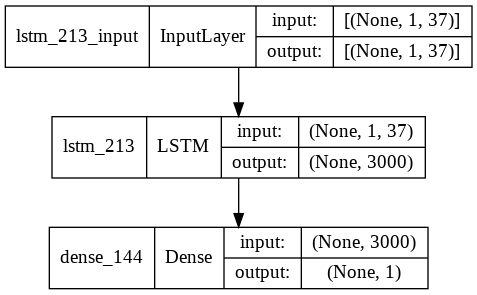

In [ ]:
disp_Image(filename=plot_LSTM1, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
data_out = '/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Resultados1_MLP.csv'       
resultados1.to_csv(data_out, index=False, encoding="ISO 8859-1")

NameError: ignored

In [ ]:
text_file = open("/content/drive/MyDrive/TFM/Data_out/Modelos RRNN/Resultados1_MLP.html", "a")
# write the CSS
text_file.write(css)
# write the HTML-ized Pandas DataFrame
text_file.write(resultados1.to_html())
text_file.close()

In [ ]:
len(y1_test)

365

In [ ]:
metrics_time_series(y1_train_inv,y1_train_pred_inv)
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9897878774434306
RSME = 6906.783319596951
MAPE = 0.007396661304500069


(0.9897878774434306, 6906.783319596951, 0.007396661304500069)

In [ ]:
metrics_time_series(y1_test_inv,y1_test_pred_inv)

R2 = 0.9112581118154426
RSME = 18517.8408789761
MAPE = 0.021214094090805054


(0.9112581118154426, 18517.8408789761, 0.021214094090805054)

##### CNN-LSTM:

PARA APLICAR LA RED CONVOLUCIONAL TENDRÍA QUE TENER "N_STEPS">=2 (MIRAR AL MENOS 2 INSTANTES DEL PASADO, PROBAR SI TENGO TIEMPO).

In [ ]:
'''
# train the model and compute the metrics
x_train_predict_CNN1, y_train_CNN1, x_test_predict_CNN1, y_test_CNN1, res_CNN1 = time_series_deep_learning(X1_train_3D, y1_train_3D, X1_test_3D, y1_test_3D, scaler_fit_ydata=scaler_y1, 
                                                                                                           n_input=125, look_back=1, unit_md1=3000, unit_md2=1000, drp1=0.30, drp2=0.15, 
                                                                                                           epcs=10**6, btch=30, model_dl=LSTM, cnn=True, plot_path=plot_BdLSTM1)
'''

In [ ]:
'''
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20, cnn=True)
'''

#### MODELO 2 (con var. 'DemPrevD1')

In [ ]:
df_results2 = pd.DataFrame()

In [ ]:
scaler_y2 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
scaler_y2.fit(y2_train)

MinMaxScaler()

In [ ]:
print(X2_train_3D.shape)
print(X2_test_3D.shape)

print(y2_train_3D.shape)
print(y2_test_3D.shape)

(730, 1, 39)
(364, 1, 39)
(730, 1, 1)
(364, 1, 1)


##### LSTM:

In [ ]:
plot_LSTM2 = path_out + 'plot_model_LSTM2.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_LSTM2, y_train_LSTM2, x_test_predict_LSTM2, y_test_LSTM2, res_LSTM2 = time_series_deep_learning(X2_train_3D, y2_train_3D, X2_test_3D, y2_test_3D, scaler_fit_ydata=scaler_y2, 
                                                                                                                n_input=39, look_back=1, unit_md1=2000, unit_md2=1000, drp1=0.20, drp2=0.10, 
                                                                                                                epcs=10**6, btch=30, model_dl=LSTM, plot_path=plot_LSTM2)

Simple Model (<class 'keras.layers.recurrent_v2.LSTM'>)


KeyboardInterrupt: ignored

In [ ]:
res_LSTM2

In [ ]:
disp_Image(filename=plot_LSTM2, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results2 = df_results2.append(res_LSTM2)

##### GRU:

In [ ]:
plot_GRU2 = path_out + 'plot_model_GRU2.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_GRU2, y_train_GRU2, x_test_predict_GRU2, y_test_GRU2, res_GRU2 = time_series_deep_learning(X2_train_3D, y2_train_3D, X2_test_3D, y2_test_3D, scaler_fit_ydata=scaler_y2, 
                                                                                                           n_input=39, look_back=1, unit_md1=2000, unit_md2=1000, drp1=0.20, drp2=0.10, 
                                                                                                           epcs=10**6, btch=30, model_dl=GRU, plot_path=plot_GRU2)

In [ ]:
res_GRU2

In [ ]:
disp_Image(filename=plot_GRU2, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results2 = df_results2.append(res_GRU2)

##### Stack LSTM:

In [ ]:
plot_StLSTM2 = path_out + 'plot_model_StLSTM2.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_StLSTM2, y_train_StLSTM2, x_test_predict_StLSTM2, y_test_StLSTM2, res_StLSTM2 = time_series_deep_learning(X2_train_3D, y2_train_3D, X2_test_3D, y2_test_3D, 
                                                                                                                          scaler_fit_ydata=scaler_y2, n_input=39, look_back=1, unit_md1=2000, 
                                                                                                                          unit_md2=1000, drp1=0.25, drp2=0.10, epcs=10**6, btch=30, 
                                                                                                                          model_dl=LSTM, stacked=True, plot_path=plot_StLSTM2)

In [ ]:
res_StLSTM2

In [ ]:
disp_Image(filename=plot_StLSTM2, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results2 = df_results2.append(res_StLSTM2)

##### Bidirectional LSTM:

In [ ]:
plot_BdLSTM2 = path_out + 'plot_model_BdLSTM2.png'

In [ ]:
# train the model and compute the metrics
x_train_predict_BdLSTM2, y_train_BdLSTM2, x_test_predict_BdLSTM2, y_test_BdLSTM2, res_BdLSTM2 = time_series_deep_learning(X2_train_3D, y2_train_3D, X2_test_3D, y2_test_3D,
                                                                                                                          scaler_fit_ydata=scaler_y2, n_input=39, look_back=1, unit_md1=3000, 
                                                                                                                          unit_md2=1000, drp1=0.30, drp2=0.15, epcs=10**6, btch=30, 
                                                                                                                          model_dl=LSTM, bidirection=True, plot_path=plot_BdLSTM2)

In [ ]:
res_BdLSTM2

In [ ]:
disp_Image(filename=plot_BdLSTM2, width=400, height=400)

In [ ]:
# plot the resuts of the prediction
#plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

In [ ]:
# save the metrics per model in the dataframe df_results
df_results2 = df_results2.append(res_BdLSTM1)

##### CNN-LSTM:

PARA APLICAR LA RED CONVOLUCIONAL TENDRÍA QUE TENER "N_STEPS">=2 (MIRAR AL MENOS 2 INSTANTES DEL PASADO, PROBAR SI TENGO TIEMPO).

In [ ]:
'''
# train the model and compute the metrics
x_train_predict_CNN2, y_train_CNN2, x_test_predict_CNN2, y_test_CNN2, res_CNN2 = time_series_deep_learning(X2_train_3D, y2_train_3D, X2_test_3D, y2_test_3D, scaler_fit_ydata=scaler_y2, 
                                                                                                           n_input=127, look_back=1, unit_md1=3000, unit_md2=1000, drp1=0.30, drp2=0.15, 
                                                                                                           epcs=10**6, btch=30, model_dl=LSTM, cnn=True, plot_path=plot_BdLSTM2)
'''

In [ ]:
'''
# train the model and compute the metrics
> x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=12, look_back=20, cnn=True)
'''

### Convolutional Neural Network model (CNNs)

Convolutional Neural Network models, or CNNs for short, can be applied to time series forecasting. There are many types of CNN models that can be used for each specific type of time series forecasting problem.

**CNN models for multivariate time series forecasting**

A problem may have two or more parallel input time series and an output time series that is dependent on the input time series. The input time series are parallel because each series has observations at the same time steps.



#### MODELO 1 (sin var. 'DemPrevD1')

In [ ]:
# Check flatten input shape (transform 3D Data to Time series data)
#n_input = X1_train_3D.shape[1] * X1_train_3D.shape[2]
#X1 = X1_train_3D.reshape((X1_train_3D.shape[0], n_input))
#X1.shape

DATOS ESTRUCTURA "3D"

Necesaria para la implementación de modelos de redes neuronales: CNN (Convolucionales) y LSTM (Long Short Term Memory)

In [ ]:
print(X1_train_3D.shape)
print(y1_train_3D.shape)

(730, 1, 125)
(730, 1, 1)


In [ ]:
print(X1_test_3D.shape)
print(y1_test_3D.shape)

(364, 1, 125)
(364, 1, 1)


DEFINIMOS RN "CNN"

In [ ]:
n_steps = X1_train_3D.shape[1]
n_steps

1

In [ ]:
n_features = X1_train_3D.shape[2]
n_features

125

In [ ]:
from keras.layers import Input

visible = Input(shape=(n_steps, n_features))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.losses import MeanSquaredError

# Define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=125, activation='relu')(visible))
#model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(7000, input_dim=n_input, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.15))
model.add(Dense(5000, input_dim=n_input, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.10))
model.add(Dense(1000, input_dim=n_input, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

TypeError: ignored

In [ ]:
# Fit model
model.fit(X1_train_ts, y1_train_ts, epochs=100, verbose=1)

Epoch 1/100
23/23 [==============================] - 1s 7ms/step - loss: 62.5294
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4864
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1794
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1357
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1089
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0876
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0637
Epoch 8/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0480
Epoch 9/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0429
Epoch 10/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 11/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 12/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 13/100
23/23 [================

In [ ]:
# demonstrate prediction
y1_pred_ts = model.predict(X1_test_ts, verbose=1)

12/12 [==============================] - 0s 1ms/step


In [ ]:
#y1_test_ts
#y1_pred_ts

In [ ]:
# Scalers (define and applied previously)
scaler_X1
scaler_y1

# Undo scaler (invert predictions)
y1_test_inv = scaler_y1.inverse_transform(y1_test_ts)
y1_pred_inv = scaler_y1.inverse_transform(y1_pred_ts)

In [ ]:
len(y1_test)

365

In [ ]:
metrics_time_series(y1_test_inv,y1_pred_inv)

R2 = 0.7164982071680426
RSME = 33035.105782088176
MAPE = 0.038095653295750175


(0.7164982071680426, 33035.105782088176, 0.038095653295750175)

In [ ]:
metrics_time_series(y1_test[n_steps:],y1_pred_inv)

R2 = 0.7164982071680426
RSME = 33035.105782088176
MAPE = 0.03809565329575017


(0.7164982071680426, 33035.105782088176, 0.03809565329575017)

R2 = 0.7164982071680426

RSME = 33035.105782088176

MAPE = 0.03809565329575017

(0.7164982071680426, 33035.105782088176, 0.03809565329575017)

In [ ]:
#save(filepath, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None, save_traces=True)

In [ ]:
#save_weights(filepath, overwrite=True, save_format=None, options=None)